# Quantum Support Vector Classifier

## Introduction

The aim of this notebook is to present the results of the application of quantum-kernel methods to solve a fraud-detection classification problem.

The best-known application of kernel methods is in classical Support Vector Machines (SVMs), supervised learning algorithms commonly used for classification tasks (in this case they are known as Support Vector Classifiers, or SVCs). The main goal of SVMs is to find decision boundaries to separate a given set of data points into classes. When these data spaces are not linearly separable, SVMs can benefit from the use of kernel functions to find these boundaries, mapping input data into a higher dimensional space, where it might be easier to solve the initial classification problem.

Mathematically, kernel functions are described by the following equation:

$k(\vec{x}_i, \vec{x}_j) = \langle f(\vec{x}_i), f(\vec{x}_j) \rangle$

where 
* $k$ is the kernel function
* $\vec{x}_i, \vec{x}_j$ are $n$ dimensional inputs
* $f$ is a map from $n$-dimension to $m$-dimension space and 
* $\langle .,, \rangle$ denotes the inner product

When considering finite data, a kernel function can be represented as a matrix, called kernel Gram matrix: 

$K_{ij} = k(\vec{x}_i,\vec{x}_j)$.

The main idea behind quantum-kernel Machine-Learning methods is to generalize classical SVMs using quantum feature maps to compute kernel matrices. 
In this case, the quantum kernel is created by mapping a classical feature vector $\vec{x}$ to a Hilbert space using a quantum feature map $\phi(\vec{x})$. 
Formally:

$K_{ij} = \left| \langle \phi(\vec{x}_i)| \phi(\vec{x}_j) \rangle \right|^{2}$

where 
* $K_{ij}$ is the kernel matrix
* $\vec{x}_i, \vec{x}_j$ are $n$ dimensional inputs
* $\phi(\vec{x})$ is the quantum feature map
* $\left| \langle .|. \rangle \right|^{2}$ denotes the the inner product of two quantum states

Then, quantum kernels can be used with classical kernel-based ML algorithms such as classical SVMs (provided, for example, in sk-learn library), or can also be used in new quantum kernel methods like QSVC (which is a generalization of classical SVC). 


Throughout the following notebook we will present all these methods, finally focusing on QSVCs. Parametric quantum kernels will then be used, and optimized through classical optimizers. All these models will then be explored for different feature maps, in order to identify the best one for this classification problem.

### Implementation note

The software is implemented using qiskit-1.0.0 stable version.
Please be sure to have installed the last version of qiskit and spin-off libraries, such as qiskit_algorithms and qiskit_machine_learning.
If this is not the case, it might be convenient to create a new conda environment with the new versions of the software.
Be sure to have also updated the spin-off libraries. To update the libraries do:
- pip install -U qiskit
- pip install -U qiskit_algorithms
- pip install -U qiskit_machine_learning
- pip install -U qiskit_ibm_runtime

The whole software is also written and organized in python files and object-oriented modules. 

## Import the dataset and select the features

In [1]:
# import accessory modules
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import clear_output
import random
from imblearn.under_sampling import RandomUnderSampler

# import ML sk-learn modules
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn import linear_model, svm
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, balanced_accuracy_score
from sklearn.metrics import roc_curve, DetCurveDisplay, RocCurveDisplay


# import qiskit modules
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap, RealAmplitudes
from qiskit import QuantumCircuit
from qiskit_algorithms.optimizers import COBYLA, SPSA, ADAM, QNSPSA, GradientDescent
from qiskit.primitives import Sampler, Estimator
from qiskit_machine_learning.algorithms import QSVC, PegasosQSVC
from qiskit.quantum_info import Statevector
from qiskit.visualization import circuit_drawer
from qiskit_algorithms.utils import algorithm_globals
from qiskit.circuit import ParameterVector
from qiskit.providers import Options
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.kernels import TrainableFidelityQuantumKernel
from qiskit_machine_learning.kernels.algorithms import QuantumKernelTrainer
import qiskit_ibm_runtime as IBMR
from qiskit_ibm_provider import IBMProvider

In [2]:
# set the seed (for testing purposes and reproducibility)
algorithm_globals.random_seed = 42
random.seed(42)

In [3]:
# import the dataset
file_path = "dataset/dataset.csv"

try:
    df = pd.read_csv(file_path)
    print("Dataset imported successfully.")
except FileNotFoundError:
    print("File not found. Please check the file path.")
    exit()

Dataset imported successfully.


The next step is to select the most important features for the classification task. It is fundamental to reduce the features' number, selecting the most relevant ones, in particular for the quantum-kernel models, in which each feature is associated to a qubit wire in the feature-map circuit, for the quantum encoding.
The feature selection is performed according to the results obtained in relative notebook (the analysis is based on the scatterplot matrix and the correlation heatmap matrix of the whole dataset). The selected features are then:
- age
- gender
- category
- amount

In [4]:
# drop the discarded features
df.drop(columns = ['step'],         inplace = True)
df.drop(columns = ['zipcodeOri'],   inplace = True)
df.drop(columns = ['zipMerchant'],  inplace = True)
df.drop(columns = ['customer'],     inplace = True)
df.drop(columns = ['merchant'],     inplace = True)

encoder = LabelEncoder()

# use the LabelEncoder method of sklearn to encode the categorical features
# Other encoding methods can be tested, such as the OneHotEncoder from sklearn
encoded_age = encoder.fit_transform(df['age'])
df['age'] = encoded_age
encoded_gender = encoder.fit_transform(df['gender'])
df['gender'] = encoded_gender
encoded_category = encoder.fit_transform(df['category'])
df['category'] = encoded_category

print(df.head())

   age  gender  category  amount  fraud
0    4       2        12    4.55      0
1    2       2        12   39.68      0
2    4       1        12   26.89      0
3    3       2        12   17.25      0
4    5       2        12   35.72      0


At this point the dataset still has some issues that need to be resolved. In particular, 
- the dataset is highly unbalanced (with 587443 frauds and 7200 non-frauds)
- and excessively large (for the time and computational costs available)

It is therefore necessary to undersample the majority class to balance the dataset and reduce its size. In this regard, we chose to use a total of 200 observations, 100 frauds and 100 non-frauds. This compromise allows both to have, as we will see, relevant values ​​for the model-evaluation metrics, and reasonable computational times, in particular for quantum kernel-based models. 

However, another version of the undersampled balanced dataset could be constructed, leaving many more observations (7200 frauds and 7200 non-frauds). This second undersampled dataset could be used to train purely classical kernel models, to be used both as a benchmark for comparison with quantum ones, and to build embedded models with classical and quantum classifiers. This second undersampled dataset will be construced in the final section, for the comparison with the classical models.

In [5]:
X = df.drop('fraud', axis=1)
y = df['fraud']

# Check class distribution
print("Class distribution before undersampling:")
print(y.value_counts())

# choose a sampling strategy, keeping a total of 200 observations
sampling_strategy = {0: 100, 1: 100}

# Undersample the majority class, using a random undersampling algorithm
# We can also fix a seed for the random undersampling, in order to have reproducibility of results
undersample = RandomUnderSampler(sampling_strategy = sampling_strategy, random_state = 42)
X_resampled, y_resampled = undersample.fit_resample(X, y)

# Check class distribution after undersampling
print("Class distribution after undersampling:")
print(pd.Series(y_resampled).value_counts())

Class distribution before undersampling:
fraud
0    587443
1      7200
Name: count, dtype: int64
Class distribution after undersampling:
fraud
0    100
1    100
Name: count, dtype: int64


Rescale all the features in the interval [0, 1], and create train and test datasets with the undersampled dataset

In [6]:
# Transform all the features in the interval [0, 1]
X_resampled = MinMaxScaler().fit_transform(X_resampled)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.3, random_state = 0)
print(X_train.shape, X_test.shape)

(140, 4) (60, 4)


In the next two cells there are some auxiliary functions, used to write the classification report of a trained model, and for plotting purposes. 

In [7]:
# given a trained model, and the train and test datasets, prints the classification report of the model
# with all the selected metrics for the evaluation
def evaluate_with_feature_map(model, X_train, y_train, X_test, y_test, feature_map_name):
    # Perform predictions on training and test sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    # the scores are necessary to compute the ROC AUC
    # using directly the predictions returned by the classifier is incorrect
    y_test_score = model.decision_function(X_test)
    
    # Print classification report and confusion matrix for training set
    print(f"Classification Report for {feature_map_name} Feature Map (Train Set):\n")
    print(classification_report(y_train, y_train_pred))
    print("Confusion Matrix for Train Set:")
    print(confusion_matrix(y_train, y_train_pred))
    print("\n")
    
    # Print classification report and confusion matrix for test set
    print(f"Classification Report for {feature_map_name} Feature Map (Test Set):\n")
    print(classification_report(y_test, y_test_pred))
    print("Confusion Matrix for Test Set:")
    print(confusion_matrix(y_test, y_test_pred))
    
    # Print ROC AUC score for test set
    print(f"ROC AUC Score for {feature_map_name} Feature Map (Test Set):")
    print(round(roc_auc_score(y_test, y_test_score), 4))
    print(70*'=')

In [8]:
def plot_features(ax, features, labels, class_label, marker, face, edge, label):
    ax.scatter(
        # x coordinate of labels
        features[np.where(labels[:] == class_label), 0],
        # y coordinate of labels
        features[np.where(labels[:] == class_label), 1],
        marker = marker,
        facecolors = face,
        edgecolors = edge,
        label = label,
    )

def plot_dataset(train_features, train_labels, test_features, test_labels, adhoc_total):
    plt.figure(figsize=(5, 5))
    plt.ylim(0, 2 * np.pi)
    plt.xlim(0, 2 * np.pi)
    plt.imshow(
        np.asmatrix(adhoc_total).T,
        interpolation = "nearest",
        origin = "lower",
        cmap = "RdBu",
        extent = [0, 2 * np.pi, 0, 2 * np.pi],
    )

## Build Quantum Support Vector Classifiers for fraud detection

In the next section, several quantum support vector classifiers will be tested on the previous dataset, and then presented the results.
In particular, there will be tested the following models:
- classical SVC (from sklearn) with the quantum kernel written by hand using a custom function, and them computing the quantum kernel Gram matrix
- classical SVC (from sklearn) with the Fidelity Quantum Kernel class from qiskit, precomputing the quantum kernel Gram matrix
- QSVC (from qiskit) with the Fidelity Quantum Kernel class, used directly in the QSVC method (we expect the same results as the method before)
- QSVC (from qiskit) with Trainable Fidelity Quantum Kernel class, optimizing the parameters of an ansatz composed with the feature maps. In this case several ansatz will be tested.

### Implement a Support Vector Classifier with a Quantum Kernel calculated "by hand"

In this case the implementation of the model follows the following phases:
- Write a function that takes two data points as input, encodes the classical data into quantum data, through a selected feature map, and returns the kernel value, as described by the equation: $K_{ij} = \left| \langle \phi(\vec{x}_i)| \phi(\vec{x}_j) \rangle \right|^{2}$
- compute the whole quantum-kernel Gram matrix $K = (K_{ij})_{i, j}$ (for the training dataset's observations)
- Build a support vector machine model (we can use a classical model such as SVC from sklearn), with the kernel parameter set to "precomputed"
- Train the SVC using the calculated quantum-kernel Gram matrix
- Test the predictions using the test dataset, computing the quantum-kernel matrix for the test observations

The first step is to encode the classical data into quantum data. This is done through 5 different feature maps:
- Z Feature Map with 1 layer:  $\phi_{Z, 1}$
- ZZ Feature Map with 1 layer:  $\phi_{ZZ, 1}$
- Pauli Feature Map with Pauli gates Z and XY (and 1 layer): $\phi_{P, 1}$
- Z Feature Map with 2 layers:  $\phi_{Z, 2}$
- ZZ Feature Map with 2 layers:  $\phi_{ZZ, 2}$

Throughout this notebook, these 5 feature maps have always been used, for all the tested models. 

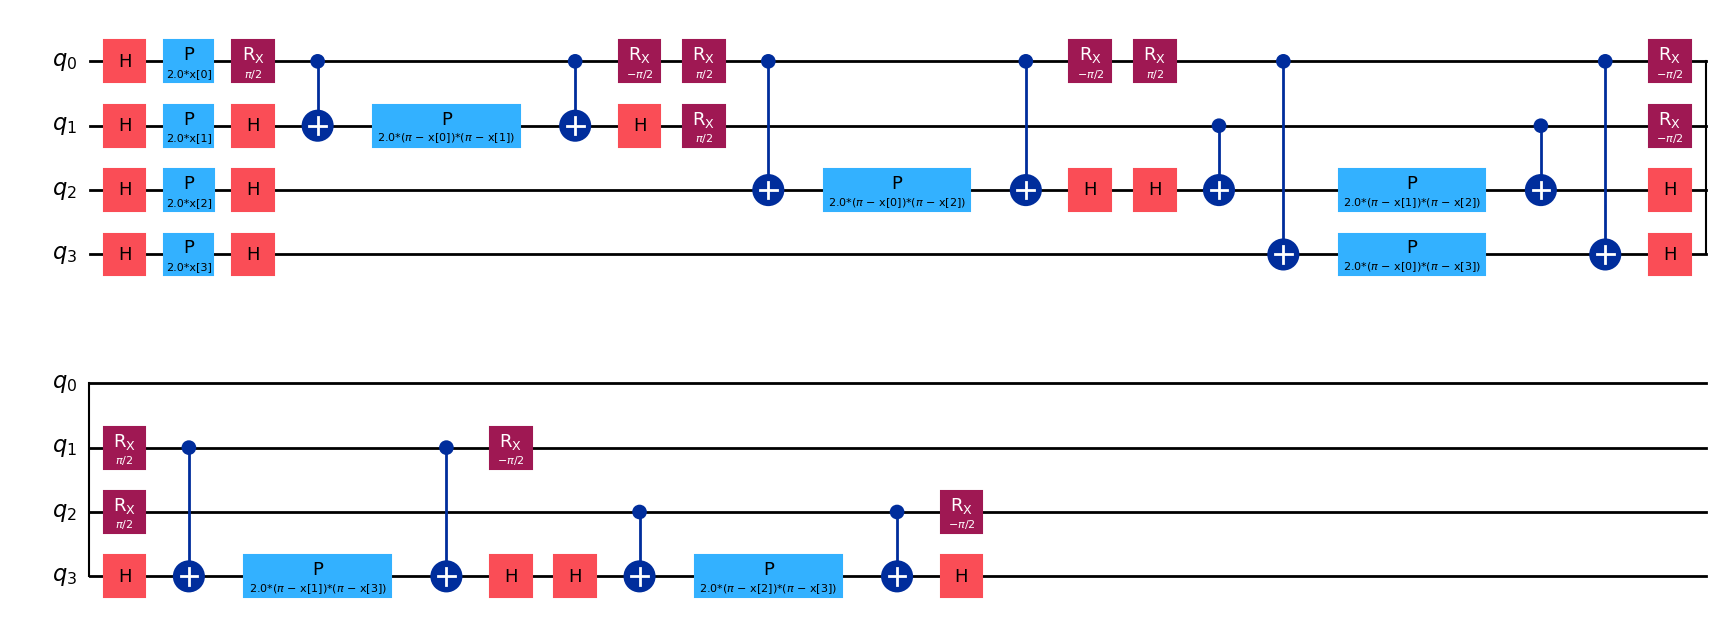

In [120]:
# compute the number of features
num_features = X.shape[1]

# create the feature maps to encode the classical data
# feature_dimension = num_features
Z = ZFeatureMap(feature_dimension = num_features, reps = 1)
ZZ = ZZFeatureMap(feature_dimension = num_features, reps = 1)
P = PauliFeatureMap(feature_dimension = num_features, reps = 1, paulis = ['Z', 'XY'])
Z2 = ZFeatureMap(feature_dimension = num_features, reps = 2)
ZZ2 = ZZFeatureMap(feature_dimension = num_features, reps = 2)

# dictionary for the feature maps' names: this will be very useful in the following 
# steps, for giving the classification reports (and plots) a better layout. 
feature_map_dict = {'Z': Z, 'ZZ': ZZ, 'Pauli(Z, XY)': P, 'Z with 2 layers': Z2, 'ZZ with 2 layers': ZZ2}

#ZZ.decompose().draw(output='mpl')
#Z.decompose().draw(output='mpl')
P.decompose().draw(output='mpl')
#ZZ2.decompose().draw(output='mpl')
#Z2.decompose().draw(output='mpl')

Create a custom function that takes two data points as input, encodes the classical data into quantum data, through a selected feature map, and returns the kernel value, as described by the equation: $K_{ij} = \left| \langle \phi(\vec{x}_i)| \phi(\vec{x}_j) \rangle \right|^{2}$

In [10]:
# import the Sampler primitive from qiskit library
sampler = Sampler()

# compute the quantum kernel, given 2 classical data points.
# In this case the Statevector is used, and the kernel is computed 
# with a simple scalar product between the two resulting statevectors
def compute_quantum_kernel_statevector(x1, x2, feature_map):
    assert len(x1) == len(x2)
    # encode the classical data into quantum data through a selected feature map
    encoded_x_i = feature_map.assign_parameters(x1)
    encoded_x_j = feature_map.assign_parameters(x2)
    # compute the quantum statevectors from the encoded data
    statevector_i = Statevector.from_instruction(encoded_x_i)
    statevector_j = Statevector.from_instruction(encoded_x_j)
    # compute the quantum kernel with a simple scalar product
    # in this case a simple linear kernel is computed, but we can choose 
    # other functions (for example polinomial functions)
    kernel_value = abs(statevector_j.conjugate().data @ statevector_i.data)**2
    return kernel_value

# compute the quantum kernel, given 2 classical data points
# In this case a quantum circuit is simulated, given a certain number of shots
def compute_quantum_kernel_overlap(x1, x2, feature_map, shots = 10):
    assert len(x1) == len(x2)
    n = len(x1)
    # encode the classical data into quantum data through a selected feature map
    encoded_x_i = feature_map.assign_parameters(x1)
    encoded_x_j = feature_map.assign_parameters(x2)
    # build the overlap quantum circuit
    qc = QuantumCircuit(n, n)
    qc.append(encoded_x_i, range(n))
    qc.append(encoded_x_j.inverse(), range(n))
    qc.measure(range(n), range(n))
    # simulate the quantum circuit, choosing an appropriate backend and a primitive
    result = sampler.run(qc, shots = shots).result()
    counts = result.quasi_dists[0]
    kernel_value = counts.get(0, 0)
    # commented lines for qiskit < 1.0.0:
    #backend = Aer.get_backend('qasm_simulator')
    #result = execute(qc, backend, shots=shots).result()
    #counts = result.get_counts()
    #kernel_value = counts.get('0' * n, 0) / shots
    return kernel_value

Compute the quantum-kernel Gram matrix for the training observations and for the test observations. Then fit the model on actual training dataset using the kernel train matrix, and compute the predictions. Finally print a classification report.
This procedure is repeted for all the five feature maps selected

In [21]:
for feature_map_name, feature_map in feature_map_dict.items():
    # Compute the train kernel Gram matrix, using the previous function
    K_train = np.array([[compute_quantum_kernel_statevector(X_train[i], X_train[j], feature_map) for j in range(len(X_train))] for i in range(len(X_train))])
    # Train the SVM (the classical sklearn SVC is used)
    qsvc = svm.SVC(kernel = 'precomputed')
    qsvc.fit(K_train, y_train)
    # Predict and compute the test kernel matrix
    K_test = np.array([[compute_quantum_kernel_statevector(X_test[i], X_train[j], feature_map) for j in range(len(X_train))] for i in range(len(X_test))])
    # print the model report
    print(f"Evaluating performance for {feature_map_name} Feature Map:\n")
    evaluate_with_feature_map(qsvc, K_train, y_train, K_test, y_test, f"{feature_map_name} (hand-computed kernel)")

Evaluating performance for Z Feature Map:

Classification Report for Z (hand-computed kernel) Feature Map (Train Set):

              precision    recall  f1-score   support

           0       0.83      0.89      0.86        71
           1       0.88      0.81      0.84        69

    accuracy                           0.85       140
   macro avg       0.85      0.85      0.85       140
weighted avg       0.85      0.85      0.85       140

Confusion Matrix for Train Set:
[[63  8]
 [13 56]]


Classification Report for Z (hand-computed kernel) Feature Map (Test Set):

              precision    recall  f1-score   support

           0       0.87      0.90      0.88        29
           1       0.90      0.87      0.89        31

    accuracy                           0.88        60
   macro avg       0.88      0.88      0.88        60
weighted avg       0.88      0.88      0.88        60

Confusion Matrix for Test Set:
[[26  3]
 [ 4 27]]
ROC AUC Score for Z (hand-computed kernel) Feat

The ROC AUC score (calculated on the test dataset) is chosen as the reference metric. Moreover, also the weighted average accuracy is displayed in the following tables. The results obtained for the different feature maps are summarized below, 
according to this evaluation metric:

|feature map|ROC AUC|Accuracy|
|:---:|:---|:---| 
|Z with 1 layer |0.9344|0.88|
|ZZ with 1 layer|0.9511|0.92|
|P(Z, XY) 1 layer|0.9077|0.92|
|Z with 2 layers|0.9310|0.88|
|ZZ with 2 layers|0.9444|0.88|

Good results have been obtained with all the feature maps used. The best feature maps seem to the ZZ (both with 1 layer and 2 layers).
The execution time of the cell, for all the feature maps, is 305 seconds (the code have been executed locally on Intel vPRO i7 with 12 physical cores).

### Build a Quantum Support Vector Classifier using the Fidelity Quantum Kernel class

In this case, instead of computing the quantum kernel with a custom function, the quantum kernel is computed directly using the Fidelity Quantum Kernel class, provided by qiskit library. Then, the quantum kernel is used:
- to compute the quantum-kernel Gram matrix, which is put in a classical SVC method
- directly in the QSVC (Quantum-SVC) method, provided by qiskit, which is an extension of the classical SVC

We expect, of course, similar or identical results, apart from the execution time.

##### plot the quantum Gram matrix for the train set and the test set with the ZZ feature map

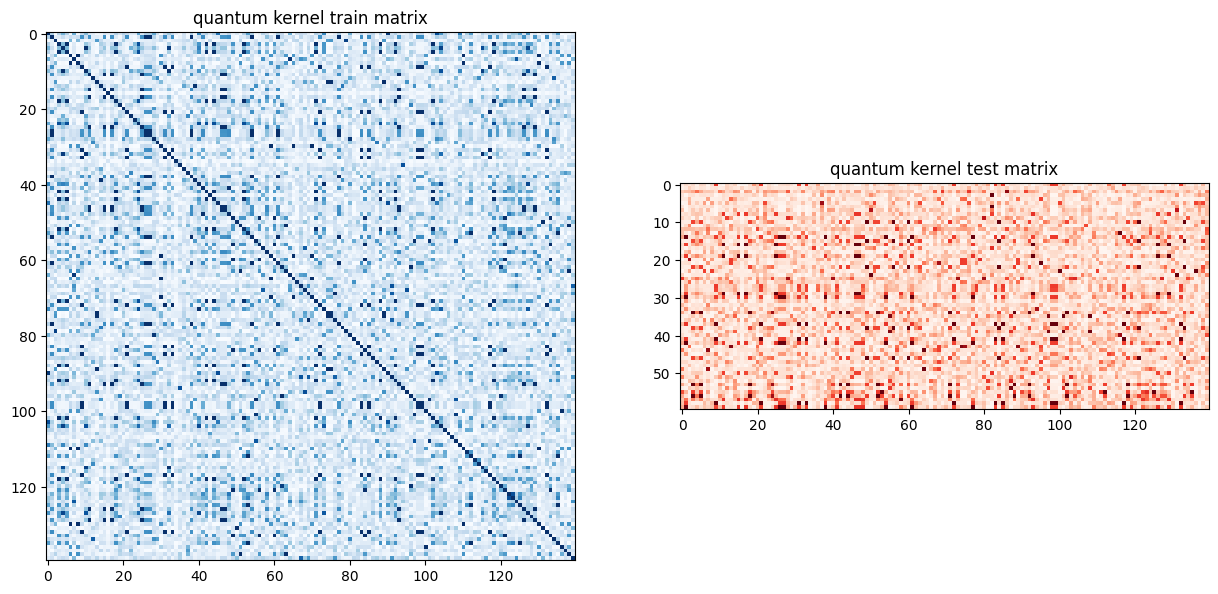

In [12]:
# plot the quantum Gram matrix for the train set and the test set:

# initialize the sampler primitive and the fidelity parameter (necessary for the FidelityQuantumKernel)
sampler = Sampler()
fidelity = ComputeUncompute(sampler = sampler)
# initilize the quantum kernel for the ZZ feature map
quantum_kernel = FidelityQuantumKernel(fidelity = fidelity, feature_map = ZZ)
# compute the kernel matrices for the train and test sets
kernel_matrix_train = quantum_kernel.evaluate(x_vec = X_train)
kernel_matrix_test  = quantum_kernel.evaluate(x_vec = X_test, y_vec = X_train)
# display the matrices
plt.figure(figsize=(15,10))
plt.subplot(121)
plt.imshow( np.asmatrix(kernel_matrix_train), interpolation = "nearest", origin = "upper", cmap = "Blues")
plt.title("quantum kernel train matrix")
plt.subplot(122)
plt.imshow(np.asmatrix(kernel_matrix_test), interpolation = "nearest", origin = "upper", cmap = "Reds")
plt.title("quantum kernel test matrix")
plt.show()

##### Compute the quantum kernel matrix for all the selected feature maps, then fit the classical SVC model and print the classification report

In [13]:
for feature_map_name, feature_map in feature_map_dict.items():
    # initilize the quantum kernel for the selected feature map
    quantum_kernel = FidelityQuantumKernel(fidelity = fidelity, feature_map = feature_map)
    # compute the quantum kernel matrices
    K_train = quantum_kernel.evaluate(x_vec = X_train)
    K_test  = quantum_kernel.evaluate(x_vec = X_test, y_vec = X_train)
    # fit the SVC model with the quantum kernel matrix
    qsvc = svm.SVC(kernel = "precomputed")
    qsvc.fit(K_train, y_train)
    # print the model report
    print(f"Evaluating performance for {feature_map_name} Feature Map:\n")
    evaluate_with_feature_map(qsvc, K_train, y_train, K_test, y_test, f"{feature_map_name} (SVC with FQK)")

Evaluating performance for Z Feature Map:

Classification Report for Z (SVC with FQK) Feature Map (Train Set):

              precision    recall  f1-score   support

           0       0.83      0.89      0.86        71
           1       0.88      0.81      0.84        69

    accuracy                           0.85       140
   macro avg       0.85      0.85      0.85       140
weighted avg       0.85      0.85      0.85       140

Confusion Matrix for Train Set:
[[63  8]
 [13 56]]


Classification Report for Z (SVC with FQK) Feature Map (Test Set):

              precision    recall  f1-score   support

           0       0.87      0.90      0.88        29
           1       0.90      0.87      0.89        31

    accuracy                           0.88        60
   macro avg       0.88      0.88      0.88        60
weighted avg       0.88      0.88      0.88        60

Confusion Matrix for Test Set:
[[26  3]
 [ 4 27]]
ROC AUC Score for Z (SVC with FQK) Feature Map (Test Set):
0.93

The results are summarized below, according to same score metrics:

|feature map|ROC AUC|Accuracy|
|:---:|:---|:---| 
|Z with 1 layer |0.9344|0.88|
|ZZ with 1 layer|0.9511|0.92|
|P(Z, XY) 1 layer|0.9077|0.92|
|Z with 2 layers|0.9310|0.88|
|ZZ with 2 layers|0.9444|0.88|

We can see that the values are the same as before, for all the feature maps. The time execution of the cell is 185 seconds.

##### Build a Support Vector Classifier with a Quantum Kernel using directly the qiskit method QSVC

In [121]:
sampler = Sampler()
fidelity = ComputeUncompute(sampler = sampler)

for feature_map_name, feature_map in feature_map_dict.items():
    quantum_kernel = FidelityQuantumKernel(fidelity = fidelity, feature_map = feature_map)
    qsvc = QSVC(quantum_kernel = quantum_kernel)
    qsvc.fit(X_train, y_train.values)
    print(f"Evaluating performance for {feature_map_name} Feature Map:\n")
    # Perform predictions and evaluate performance metrics
    evaluate_with_feature_map(qsvc, X_train, y_train.values, X_test, y_test.values, feature_map_name)

Evaluating performance for Z Feature Map:

Classification Report for Z Feature Map (Train Set):

              precision    recall  f1-score   support

           0       0.83      0.89      0.86        71
           1       0.88      0.81      0.84        69

    accuracy                           0.85       140
   macro avg       0.85      0.85      0.85       140
weighted avg       0.85      0.85      0.85       140

Confusion Matrix for Train Set:
[[63  8]
 [13 56]]


Classification Report for Z Feature Map (Test Set):

              precision    recall  f1-score   support

           0       0.87      0.90      0.88        29
           1       0.90      0.87      0.89        31

    accuracy                           0.88        60
   macro avg       0.88      0.88      0.88        60
weighted avg       0.88      0.88      0.88        60

Confusion Matrix for Test Set:
[[26  3]
 [ 4 27]]
ROC AUC Score for Z Feature Map (Test Set):
0.9344
Evaluating performance for ZZ Feature Map:

We obtain the same result as before for for all the feature maps, proving that all these methods are equivalent:

|feature map|ROC AUC|Accuracy|
|:---:|:---|:---| 
|Z with 1 layer |0.9344|0.88|
|ZZ with 1 layer|0.9511|0.92|
|P(Z, XY) 1 layer|0.9077|0.92|
|Z with 2 layers|0.9310|0.88|
|ZZ with 2 layers|0.9444|0.88|

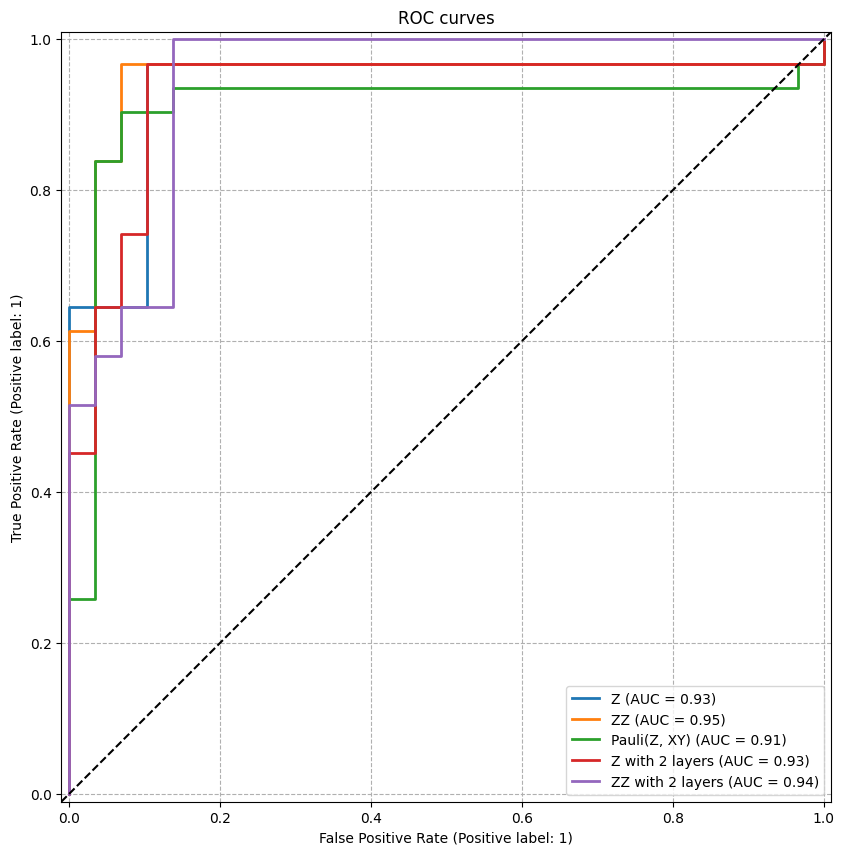

In [123]:
# plot the ROC curves
fig, ax_roc = plt.subplots(1, 1, figsize = (10, 10))

for feature_map_name, feature_map in feature_map_dict.items():
    quantum_kernel = FidelityQuantumKernel(fidelity = fidelity, feature_map = feature_map)
    qsvc = QSVC(quantum_kernel = quantum_kernel)
    # Fit the QSVC
    qsvc.fit(X_train, y_train)
    RocCurveDisplay.from_estimator(qsvc, X_test, y_test, ax = ax_roc, name = feature_map_name, lw = 2)

ax_roc.set_title("ROC curves")
ax_roc.grid(linestyle = "--")
ax_roc.axline((0, 0), slope = 1, color = 'k', linestyle = '--')
plt.legend()
plt.show()

## Build Quantum SVCs using Trainable Quantum Kernels

In the next section trainable quantum kernels will be used, instantiating the *TrainableFidelityQuantumKernel* and *QuantumKernelTrainer* classes. The aim of this section is to use parametric quantum circuits (or ansatz) to combine with the previous feature maps ($\phi_{Z, 1}$, $\phi_{ZZ, 1}$, $\phi_{P}$, $\phi_{Z, 2}$, $\phi_{ZZ, 2}$), in order to obtain new parametric feature maps to encode classical data. An optimizer is then used to find the optimal value of the ansatz parameters, and thus the optimal kernel (for a certain feature map). Once obtained the optimal kernel, it will be used to build a QSVC method, and see if the results improve compared to the previous case. In this case it is also possible to follow the training process of quantum kernels with a callback function.

In [15]:
# set up the callback function (for the SPSA optimizer)
class QKTCallback:

    def __init__(self) -> None:
        self._data = [[] for i in range(5)]

    def callback(self, x0, x1 = None, x2 = None, x3 = None, x4 = None):
        """
        Args (from the qiskit documentation):
            x0: number of function evaluations
            x1: the parameters
            x2: the function value
            x3: the stepsize
            x4: whether the step was accepted
        """
        self._data[0].append(x0)
        self._data[1].append(x1)
        self._data[2].append(x2)
        self._data[3].append(x3)
        self._data[4].append(x4)

    def get_callback_data(self):
        return self._data

    def clear_callback_data(self):
        self._data = [[] for i in range(5)]

#### Single rotation layer with one parameter

In [59]:
# create the feature maps
Z = ZFeatureMap(feature_dimension = num_features, reps = 1)
ZZ = ZZFeatureMap(feature_dimension = num_features, reps = 1)
P = PauliFeatureMap(feature_dimension = num_features, reps = 1, paulis = ['Z', 'XY'])
Z2 = ZFeatureMap(feature_dimension = num_features, reps = 2)
ZZ2 = ZZFeatureMap(feature_dimension = num_features, reps = 2)

# Create a parametrized layer to train. Rotate each qubit the same amount
training_params = ParameterVector("θ", 1)
ansatz_layer = QuantumCircuit(num_features)
for i in range(num_features):
    ansatz_layer.ry(training_params[0], i)

# Create the trainable feature maps, composed of two circuits: 
# the ansatz and the previous feature map
Z_param   = ansatz_layer.compose(Z)
ZZ_param  = ansatz_layer.compose(ZZ)
P_param   = ansatz_layer.compose(P)
Z2_param  = ansatz_layer.compose(Z2)
ZZ2_param = ansatz_layer.compose(ZZ2)

parametric_feature_map_dict = {'Z': Z_param, 'ZZ': ZZ_param, 'Pauli(Z, XY)': P_param, 'Z with 2 layers': Z2_param, 'ZZ with 2 layers': ZZ2_param}

print(circuit_drawer(ZZ_param))
print(f"Trainable parameters: {training_params}")

     ┌──────────┐┌────────────────────────────────────┐
q_0: ┤ Ry(θ[0]) ├┤0                                   ├
     ├──────────┤│                                    │
q_1: ┤ Ry(θ[0]) ├┤1                                   ├
     ├──────────┤│  ZZFeatureMap(x[0],x[1],x[2],x[3]) │
q_2: ┤ Ry(θ[0]) ├┤2                                   ├
     ├──────────┤│                                    │
q_3: ┤ Ry(θ[0]) ├┤3                                   ├
     └──────────┘└────────────────────────────────────┘
Trainable parameters: θ, ['θ[0]']


Train the Quantum Kernel with the ZZ feature map (with 2 layers), then plot the loss function and the optimal-kernel train matrix.
Build the QSVC model with the optimal kernel, and finally print the classification report.

In [60]:
# Instantiate the trainable quantum kernel form qiskit library
sampler = Sampler()
fidelity = ComputeUncompute(sampler = sampler)
# set up the trainable quantum kernel
quantum_kernel = TrainableFidelityQuantumKernel(fidelity = fidelity, feature_map = ZZ2_param, training_parameters = training_params)

# Set up the optimizer
qkt_callback = QKTCallback()
optimizer = SPSA(maxiter = 20, callback = qkt_callback.callback, learning_rate = 0.02, perturbation = 0.02)
#optimizer = COBYLA(maxiter = 20)

# Instantiate a quantum kernel trainer, to manage the training process
qkt = QuantumKernelTrainer(quantum_kernel = quantum_kernel, loss = "svc_loss", optimizer = optimizer, initial_point = [np.pi / 2])

# Train the kernel using QKT directly
qkt_results = qkt.fit(X_train, y_train)
optimized_kernel = qkt_results.quantum_kernel
print(qkt_results)

{   'optimal_circuit': None,
    'optimal_parameters': {ParameterVectorElement(θ[0]): 2.3114160189710784},
    'optimal_point': array([2.31141602]),
    'optimal_value': 35.50554208579471,
    'optimizer_evals': 60,
    'optimizer_result': None,
    'optimizer_time': None,
    'quantum_kernel': <qiskit_machine_learning.kernels.trainable_fidelity_quantum_kernel.TrainableFidelityQuantumKernel object at 0x7f2b8b879ac0>}


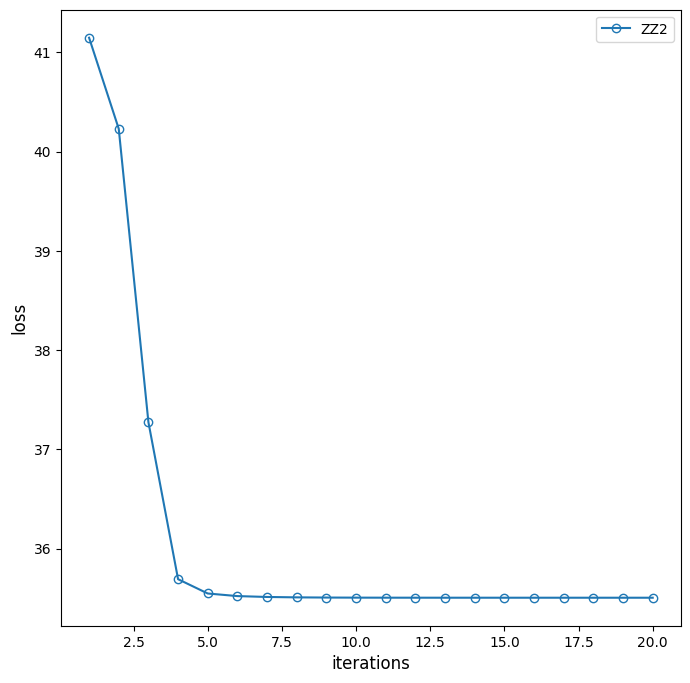

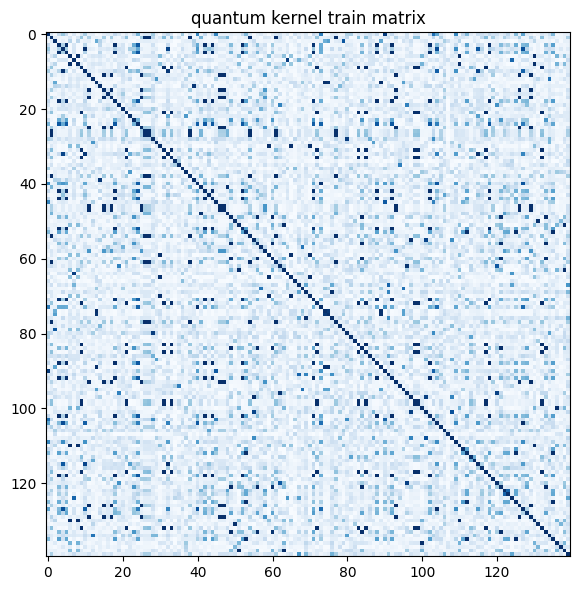

In [61]:
# visualize the training process of the quantum kernel
plot_data = qkt_callback.get_callback_data()
# compute kernel matrix evaluated on the training observations
optimized_kernel_matrix_train = optimized_kernel.evaluate(X_train)

# plot the loss function 
fig = plt.figure(figsize=(8,8))
plt.plot([i + 1 for i in range(len(plot_data[0]))], np.array(plot_data[2]), marker = 'o', mfc = 'none', label = 'ZZ2')
plt.xlabel("iterations", fontsize = 12)
plt.ylabel("loss", fontsize = 12)
plt.legend()
plt.show()
# plot the optimal kernel Gram matrix for the training observations
fig = plt.figure(figsize=(6,6))
plt.title("quantum kernel train matrix")
plt.imshow(optimized_kernel_matrix_train, interpolation = "nearest", origin = "upper", cmap = "Blues")
fig.tight_layout()
plt.show()

In [62]:
# pass the trained quantum kernel to a ML kernel-based model (in this case the QSVC method of qiskit), 
# then fit the model and test on the test dataset
qsvc = QSVC(quantum_kernel = optimized_kernel)
# Fit the QSVC
qsvc.fit(X_train, y_train)
# print the classification report
print(f"Evaluating performance for ZZ with 2 layers Feature Map:\n")
evaluate_with_feature_map(qsvc, X_train, y_train, X_test, y_test, 'ZZ with 2 layers')

Evaluating performance for ZZ with 2 layers Feature Map:

Classification Report for ZZ with 2 layers Feature Map (Train Set):

              precision    recall  f1-score   support

           0       0.99      0.94      0.96        71
           1       0.94      0.99      0.96        69

    accuracy                           0.96       140
   macro avg       0.96      0.96      0.96       140
weighted avg       0.97      0.96      0.96       140

Confusion Matrix for Train Set:
[[67  4]
 [ 1 68]]


Classification Report for ZZ with 2 layers Feature Map (Test Set):

              precision    recall  f1-score   support

           0       0.87      0.90      0.88        29
           1       0.90      0.87      0.89        31

    accuracy                           0.88        60
   macro avg       0.88      0.88      0.88        60
weighted avg       0.88      0.88      0.88        60

Confusion Matrix for Test Set:
[[26  3]
 [ 4 27]]
ROC AUC Score for ZZ with 2 layers Feature Map (

Repet the whole process for all the selected feature maps, then summarize the results.

In [63]:
# run on ibm quntum: import the Sampler class from IBM Qiskit Runtime
#service = IBMR.QiskitRuntimeService()#channel = "ibm_quantum")
#backend = service.get_backend("ibmq_qasm_simulator")
# Set options to (eventually to include noise models)
#options = IBMR.Options()
#options.execution.shots = 1000
#options.optimization_level = 3
#options.resilience_level = 0
#sampler = IBMR.Sampler(backend = backend)

# local run: instantiate the Sampler class from qiskit
sampler = Sampler()
fidelity = ComputeUncompute(sampler = sampler)

optimized_kernels = {}
callback_data = []
# set up the optimizer
qkt_callback = QKTCallback()
#optimizer = SPSA(maxiter = 20, callback = qkt_callback.callback, learning_rate = 0.02, perturbation = 0.02)
#optimizer = COBYLA(maxiter = 20)

# train the quantum kernel for all the feature maps
for feature_map_name, feature_map in parametric_feature_map_dict.items():
    quantum_kernel = TrainableFidelityQuantumKernel(fidelity = fidelity, feature_map = feature_map, training_parameters = training_params)
    # take a different learning rate for the feature maps
    if (feature_map_name == 'Z' or feature_map_name == 'Pauli(Z, XY)'):
        optimizer = SPSA(maxiter = 20, callback = qkt_callback.callback, learning_rate = 0.05, perturbation = 0.05)
    else:
        optimizer = SPSA(maxiter = 20, callback = qkt_callback.callback, learning_rate = 0.02, perturbation = 0.02)
    qkt = QuantumKernelTrainer(quantum_kernel = quantum_kernel, loss = "svc_loss", optimizer = optimizer, initial_point = [np.pi / 2])
    # Train the kernel
    qkt_results = qkt.fit(X_train, y_train)
    # store in a dictionary the optimal quantum kernel found
    optimized_kernels[feature_map_name] = qkt_results.quantum_kernel
    # get the callback data
    callback_data.append(qkt_callback.get_callback_data())
    qkt_callback.clear_callback_data()

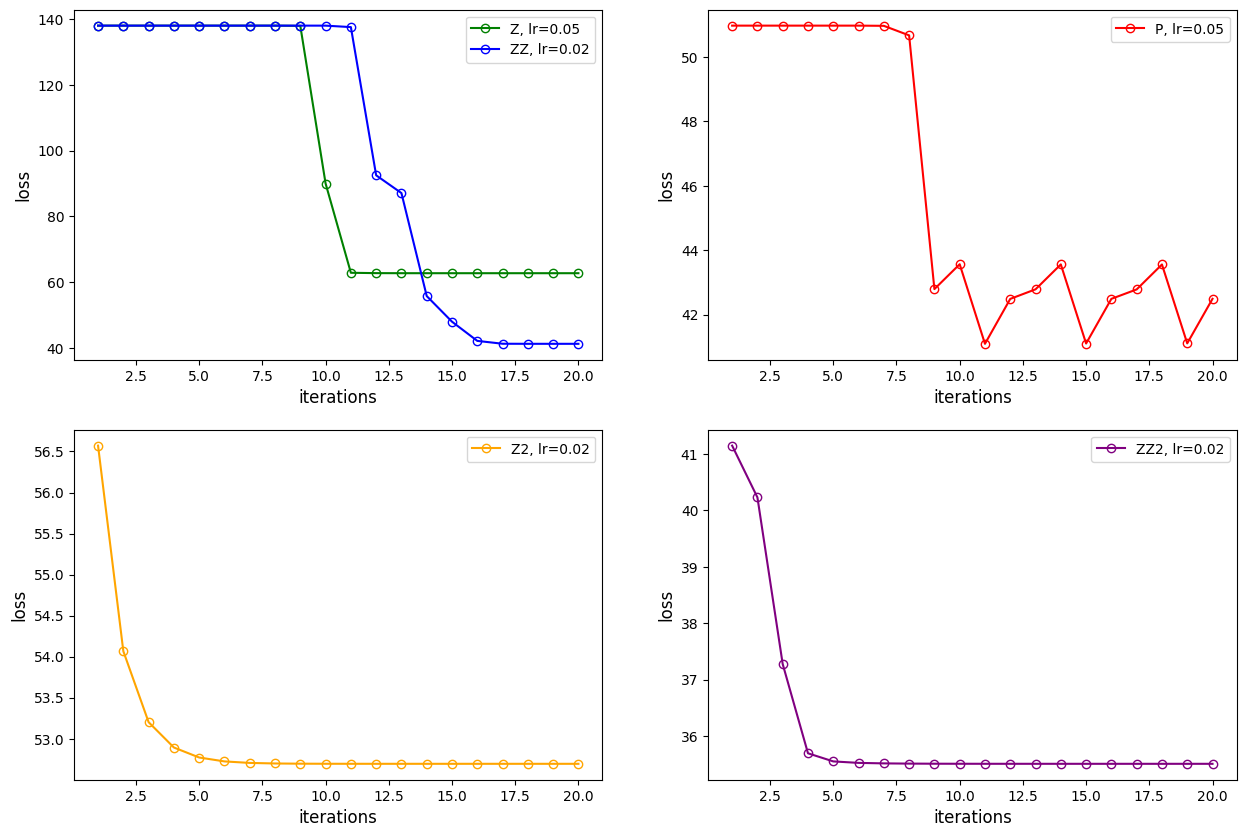

In [64]:
# visualize the training process for all the feature maps

fig = plt.figure(figsize=(15,10))
plt.subplot(221)
plt.plot([i + 1 for i in range(len(callback_data[0][0]))], np.array(callback_data[0][2]), marker = 'o', mfc = 'none', color = 'green', label = 'Z, lr=0.05')
plt.plot([i + 1 for i in range(len(callback_data[1][0]))], np.array(callback_data[1][2]), marker = 'o', mfc = 'none', color = 'blue', label = 'ZZ, lr=0.02')
plt.xlabel("iterations", fontsize = 12)
plt.ylabel("loss", fontsize = 12)
plt.legend()
plt.subplot(222)
plt.plot([i + 1 for i in range(len(callback_data[2][0]))], np.array(callback_data[2][2]), marker = 'o', mfc = 'none', color = 'red', label = 'P, lr=0.05')
plt.xlabel("iterations", fontsize = 12)
plt.ylabel("loss", fontsize = 12)
plt.legend()
plt.subplot(223)
plt.plot([i + 1 for i in range(len(callback_data[3][0]))], np.array(callback_data[3][2]), marker = 'o', mfc = 'none', color = 'orange', label = 'Z2, lr=0.02')
plt.xlabel("iterations", fontsize = 12)
plt.ylabel("loss", fontsize = 12)
plt.legend()
plt.subplot(224)
plt.plot([i + 1 for i in range(len(callback_data[4][0]))], np.array(callback_data[4][2]), marker = 'o', mfc = 'none', color = 'purple', label = 'ZZ2, lr=0.02')
plt.xlabel("iterations", fontsize = 12)
plt.ylabel("loss", fontsize = 12)
plt.legend()
plt.show()

In [65]:
# fit the QSVC model with the optimal kernels for all the feature maps, 
# and print the classification report
for feature_map_name, optimized_kernel in optimized_kernels.items():
    qsvc = QSVC(quantum_kernel = optimized_kernel)
    # Fit the QSVC
    qsvc.fit(X_train, y_train.values)
    print(f"Evaluating performance for {feature_map_name} Feature Map:\n")
    # Perform predictions and evaluate performance metrics
    evaluate_with_feature_map(qsvc, X_train, y_train.values, X_test, y_test.values, feature_map_name)

Evaluating performance for Z Feature Map:

Classification Report for Z Feature Map (Train Set):

              precision    recall  f1-score   support

           0       0.83      0.89      0.86        71
           1       0.88      0.81      0.84        69

    accuracy                           0.85       140
   macro avg       0.85      0.85      0.85       140
weighted avg       0.85      0.85      0.85       140

Confusion Matrix for Train Set:
[[63  8]
 [13 56]]


Classification Report for Z Feature Map (Test Set):

              precision    recall  f1-score   support

           0       0.87      0.90      0.88        29
           1       0.90      0.87      0.89        31

    accuracy                           0.88        60
   macro avg       0.88      0.88      0.88        60
weighted avg       0.88      0.88      0.88        60

Confusion Matrix for Test Set:
[[26  3]
 [ 4 27]]
ROC AUC Score for Z Feature Map (Test Set):
0.9344
Evaluating performance for ZZ Feature Map:

We can summarize the results below, according to the ROC AUC score and the weighted average accuracy score:

|feature map|ROC AUC|Accuracy|
|:---:|:---|:---| 
|Z with 1 layer |0.9344|0.88|
|ZZ with 1 layer|0.9511|0.92|
|P(Z, XY) 1 layer|**0.9388**|0.92|
|Z with 2 layers|**0.9321**|0.88|
|ZZ with 2 layers|**0.9466**|0.88|

The results are quite similar to the previous case (non-trainable quantum kernels). In particular, there is a little improvement in the ROC AUC score for the feature maps highlighted in bold. We can also notice that all the loss functions decrease rapidly to a saturation level, except for the Pauli feature map, which begins to show a periodic behaviour. It was also necessary to adjust and differentiate the learning rate for the various feature maps, in order to obtain a monotone behavior of the loss function, as far as possible.

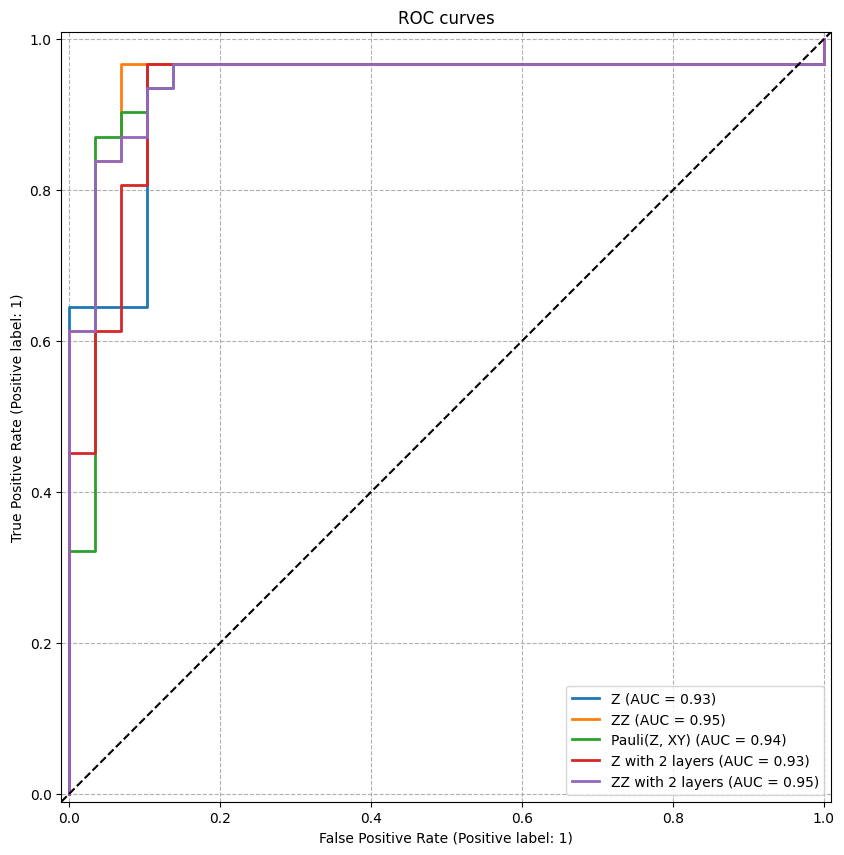

In [66]:
# plot the ROC curves
fig, ax_roc = plt.subplots(1, 1, figsize = (10, 10))

for feature_map_name, optimized_kernel in optimized_kernels.items():
    qsvc = QSVC(quantum_kernel = optimized_kernel)
    # Fit the QSVC
    qsvc.fit(X_train, y_train.values)
    RocCurveDisplay.from_estimator(qsvc, X_test, y_test, ax = ax_roc, name = feature_map_name, lw = 2)

ax_roc.set_title("ROC curves")
ax_roc.grid(linestyle = "--")
ax_roc.axline((0, 0), slope = 1, color = 'k', linestyle = '--')
plt.legend()
plt.show()

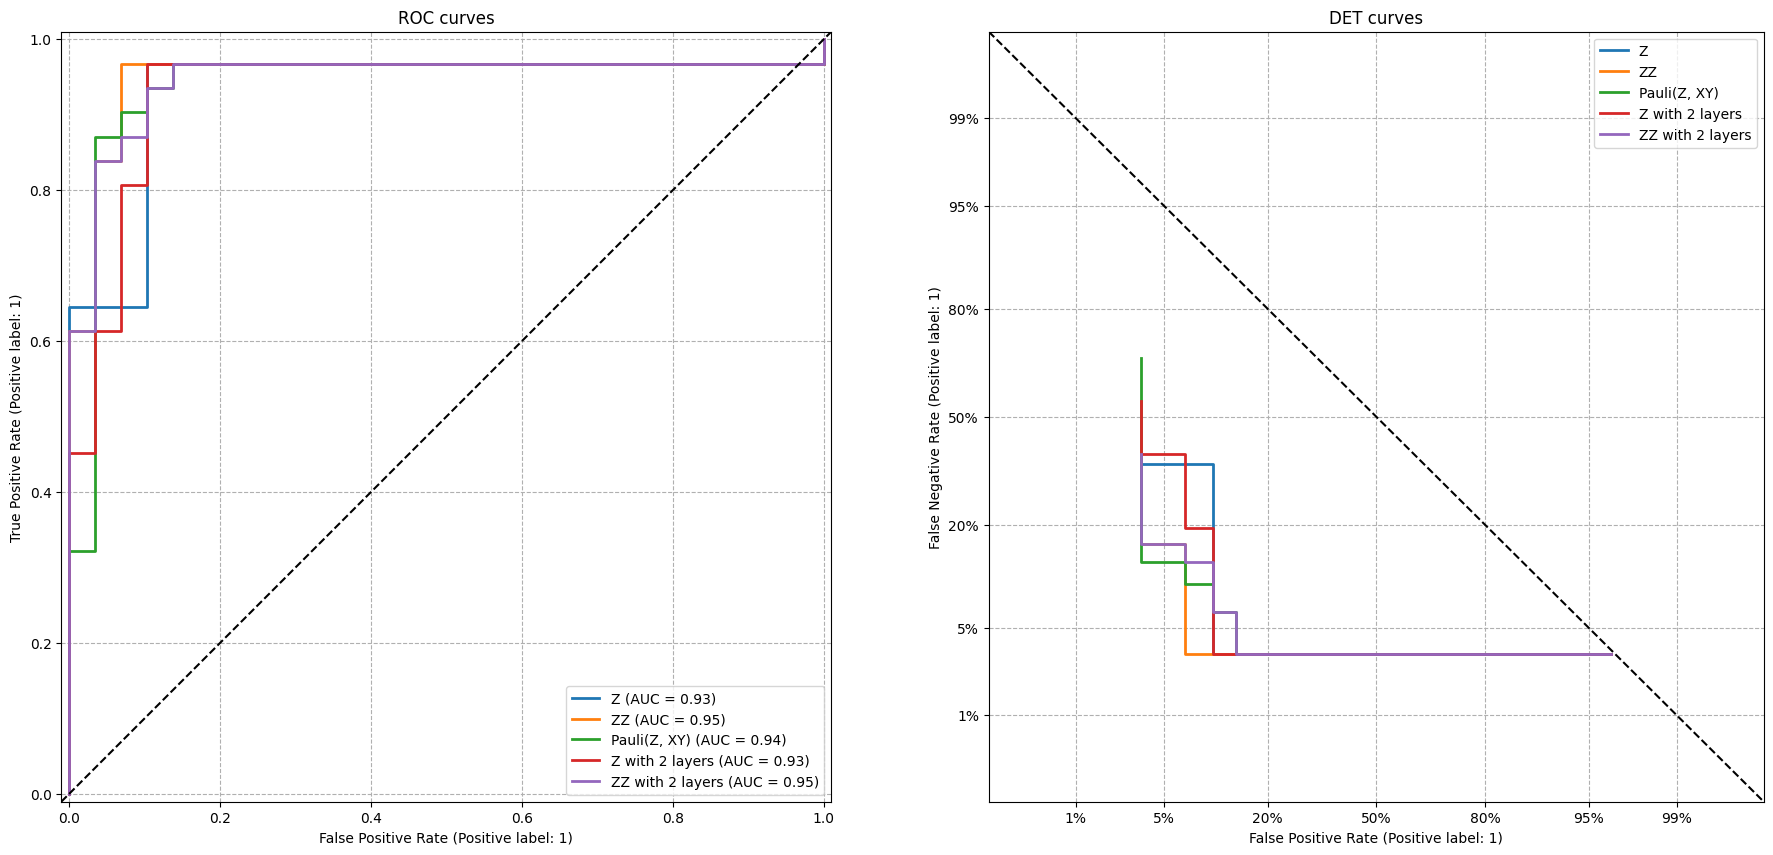

In [67]:
# plot the ROC and DET curves
fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize = (22, 10))

for feature_map_name, optimized_kernel in optimized_kernels.items():
    qsvc = QSVC(quantum_kernel = optimized_kernel)
    # Fit the QSVC
    qsvc.fit(X_train, y_train.values)
    RocCurveDisplay.from_estimator(qsvc, X_test, y_test.values, ax = ax_roc, name = feature_map_name, lw = 2)
    DetCurveDisplay.from_estimator(qsvc, X_test, y_test.values, ax = ax_det, name = feature_map_name, lw = 2)

ax_roc.set_title("ROC curves")
ax_det.set_title("DET curves")
ax_roc.grid(linestyle = "--")
ax_det.grid(linestyle = "--")
ax_roc.axline((0, 0), slope = 1, color = 'k', linestyle = '--')
ax_det.axline((0, 0), slope = -1, color = 'k', linestyle = '--')
plt.legend()
plt.show()

#### Single rotation layer, with multiple parameters (one for each qubit)

In this case each qubit is free to rotate for a certain amount independently, so the number of parameters to optimize is equal to the number of qubits, that is equal to the number of features. The steps followed are identical to the previous case.

In [71]:
# Create a parametrized layer to train. 
# Now we let each qubit rotate for different amount
training_params = ParameterVector("θ", num_features)
ansatz_layer = QuantumCircuit(num_features)
for i in range(num_features):
    ansatz_layer.ry(training_params[i], i)

# Create the trainable feature maps, composed of two circuits: 
# the ansatz and the previous feature map
Z_param   = ansatz_layer.compose(Z)
ZZ_param  = ansatz_layer.compose(ZZ)
P_param   = ansatz_layer.compose(P)
Z2_param  = ansatz_layer.compose(Z2)
ZZ2_param = ansatz_layer.compose(ZZ2)

parametric_feature_map_dict = {'Z': Z_param, 'ZZ': ZZ_param, 'Pauli(Z, XY)': P_param, 'Z with 2 layers': Z2_param, 'ZZ with 2 layers': ZZ2_param}

print(circuit_drawer(ZZ_param))
print(f"Trainable parameters: {training_params}")

     ┌──────────┐┌────────────────────────────────────┐
q_0: ┤ Ry(θ[0]) ├┤0                                   ├
     ├──────────┤│                                    │
q_1: ┤ Ry(θ[1]) ├┤1                                   ├
     ├──────────┤│  ZZFeatureMap(x[0],x[1],x[2],x[3]) │
q_2: ┤ Ry(θ[2]) ├┤2                                   ├
     ├──────────┤│                                    │
q_3: ┤ Ry(θ[3]) ├┤3                                   ├
     └──────────┘└────────────────────────────────────┘
Trainable parameters: θ, ['θ[0]', 'θ[1]', 'θ[2]', 'θ[3]']


In [72]:
# to run on ibm quntum, import the Sampler class from IBM Qiskit Runtime, not Qiskit
#service = IBMR.QiskitRuntimeService()#channel = "ibm_quantum")#, token = "88eeb7f45dcf7770dc57b658d3a7777feba57f28d40e8790d737aea341704a16da5e7163756b82a020919f20b6ccf8c300efed8abb45b2a5a531dcbc7253e51f")
#backend = service.get_backend("ibmq_qasm_simulator")
# Set options to (eventually to include noise models)
#options = IBMR.Options()
#options.execution.shots = 1000
#options.optimization_level = 3
#options.resilience_level = 0
#sampler = IBMR.Sampler(backend = backend)

# to run locally: instantiate the Sampler class from qiskit
sampler = Sampler()
# initialize the fidelity parameter for the TrainableFidelityQuantumKernel
fidelity = ComputeUncompute(sampler = sampler)

optimized_kernels = {}
callback_data = []
# set up the callback function
qkt_callback = QKTCallback()
#optimizer = SPSA(maxiter = 50, callback = qkt_callback.callback, learning_rate = 0.05, perturbation = 0.05)

# perform the optimization of the kernel for all the feature maps, and store the optimized kernels
for feature_map_name, feature_map in parametric_feature_map_dict.items():
    quantum_kernel = TrainableFidelityQuantumKernel(fidelity = fidelity, feature_map = feature_map, training_parameters = training_params)
    # the appropriate learning rate can be different for each feature map. The selection of a certain leraning rate
    # is based on heuristic criteria, and there is no fized rule for choosing a specific value. The choice of an optimal
    # value for the learning rate (and the perturbation) is based on multiple testing
    if (feature_map_name == 'ZZ'):
        optimizer = SPSA(maxiter = 50, callback = qkt_callback.callback, learning_rate = 0.01, perturbation = 0.01)
    elif (feature_map_name == 'Z'):
        optimizer = SPSA(maxiter = 50, callback = qkt_callback.callback, learning_rate = 0.04, perturbation = 0.04)
    else:
        optimizer = SPSA(maxiter = 50, callback = qkt_callback.callback, learning_rate = 0.05, perturbation = 0.05)
    qkt = QuantumKernelTrainer(quantum_kernel = quantum_kernel, loss = "svc_loss", optimizer = optimizer)
    # Train the kernel
    qkt_results = qkt.fit(X_train, y_train.values)
    # save the results
    optimized_kernels[feature_map_name] = qkt_results.quantum_kernel
    callback_data.append(qkt_callback.get_callback_data())
    qkt_callback.clear_callback_data()

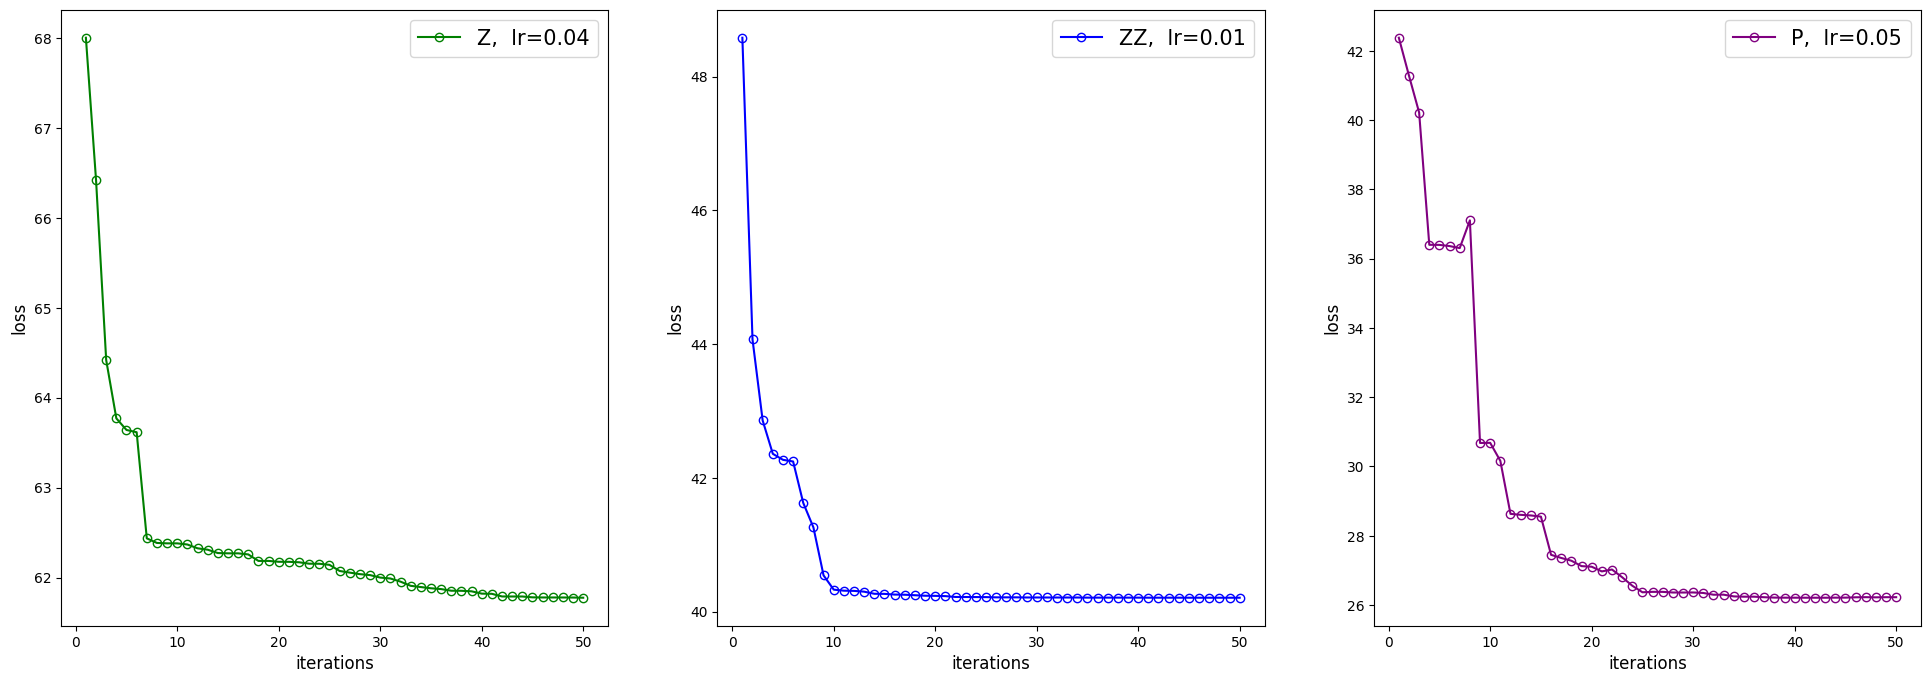

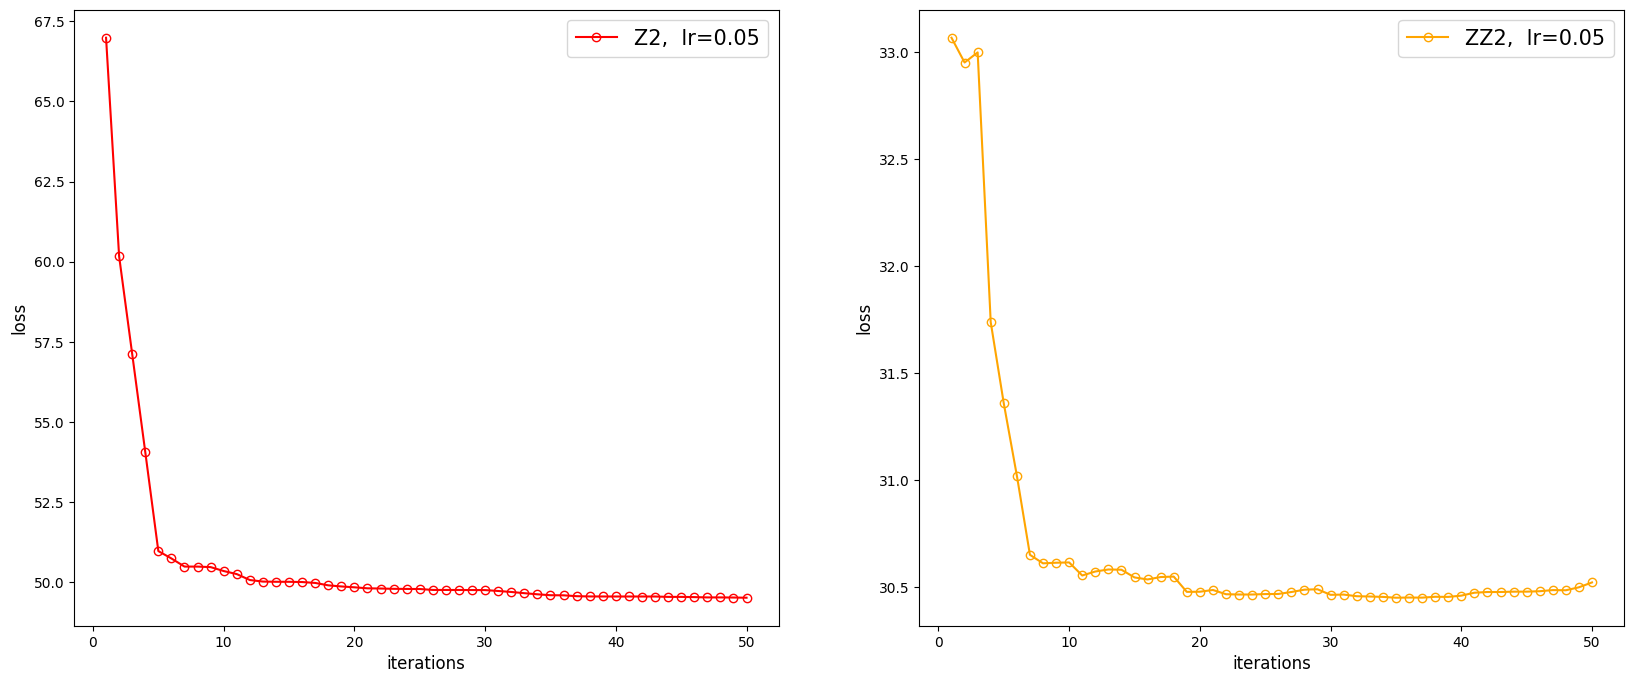

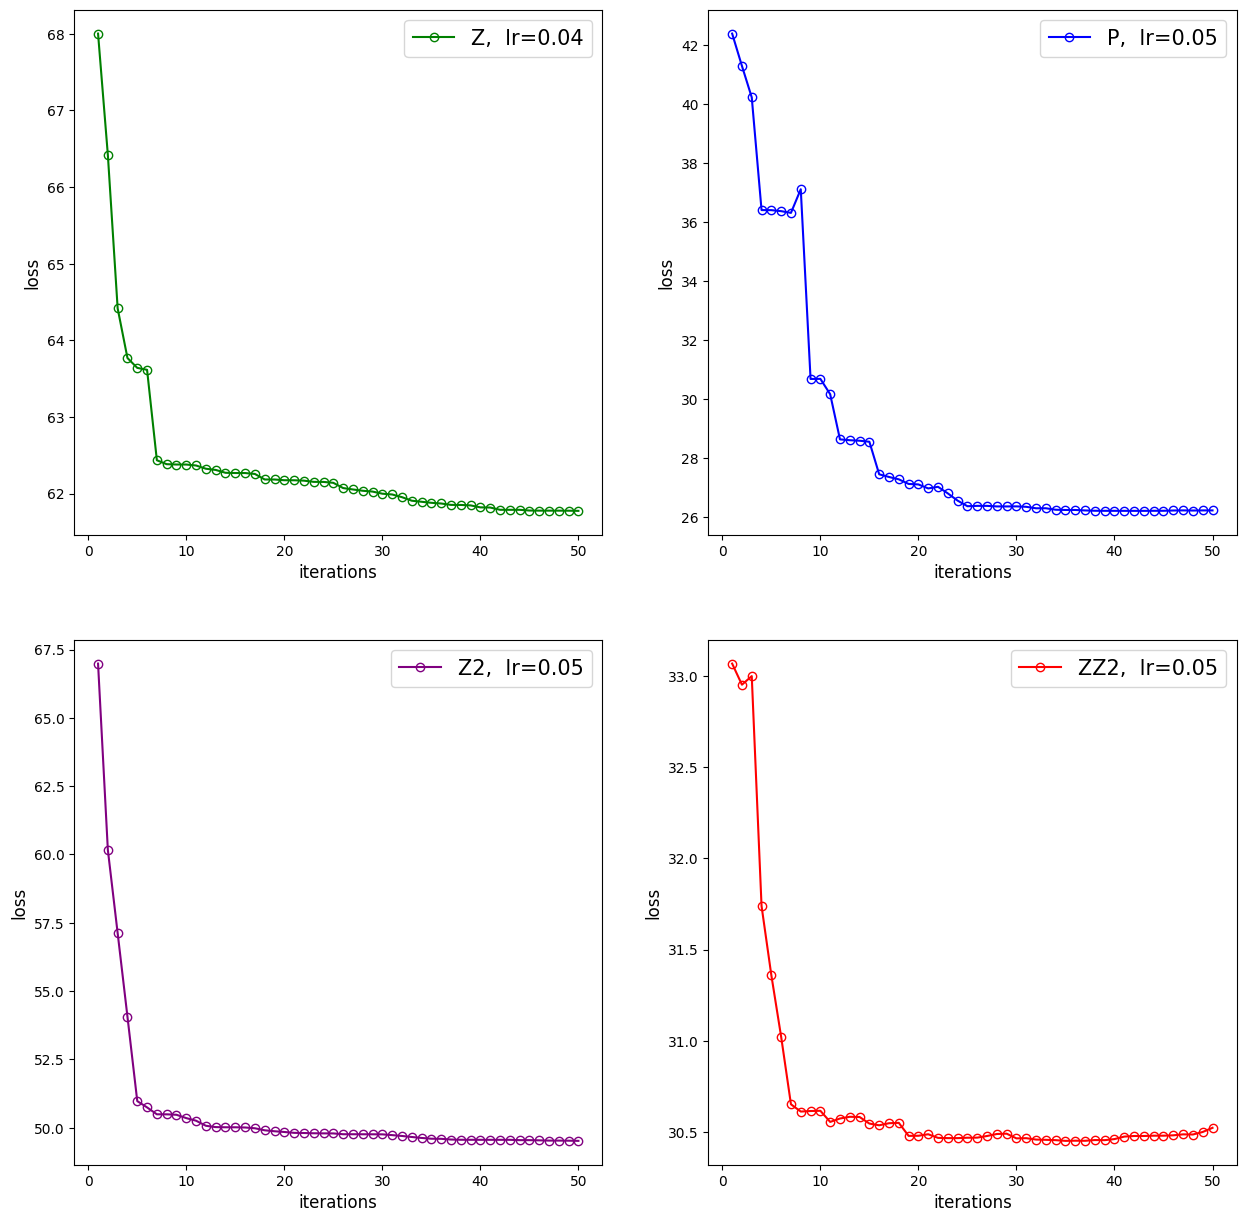

In [81]:
# visualize the training process for all the feature maps

fig = plt.figure(figsize=(24,8))
plt.subplot(131)
plt.plot([i + 1 for i in range(len(callback_data[0][0]))], np.array(callback_data[0][2]), marker = 'o', mfc = 'none', color = 'green', label = 'Z,  lr=0.04')
plt.xlabel("iterations", fontsize = 12)
plt.ylabel("loss", fontsize = 12)
plt.legend(fontsize = "15")
plt.subplot(132)
plt.plot([i + 1 for i in range(len(callback_data[1][0]))], np.array(callback_data[1][2]), marker = 'o', mfc = 'none', color = 'blue', label = 'ZZ,  lr=0.01')
plt.xlabel("iterations", fontsize = 12)
plt.ylabel("loss", fontsize = 12)
plt.legend(fontsize = "15")
plt.subplot(133)
plt.plot([i + 1 for i in range(len(callback_data[2][0]))], np.array(callback_data[2][2]), marker = 'o', mfc = 'none', color = 'purple', label = 'P,  lr=0.05')
plt.xlabel("iterations", fontsize = 12)
plt.ylabel("loss", fontsize = 12)
plt.legend(fontsize = "15")
plt.show()

fig = plt.figure(figsize=(20,8))
plt.subplot(121)
plt.plot([i + 1 for i in range(len(callback_data[3][0]))], np.array(callback_data[3][2]), marker = 'o', mfc = 'none', label = 'Z2,  lr=0.05', color = 'red')
plt.xlabel("iterations", fontsize = 12)
plt.ylabel("loss", fontsize = 12)
plt.legend(fontsize = "15")
plt.subplot(122)
plt.plot([i + 1 for i in range(len(callback_data[4][0]))], np.array(callback_data[4][2]), marker = 'o', mfc = 'none', label = 'ZZ2,  lr=0.05', color = 'orange')
plt.xlabel("iterations", fontsize = 12)
plt.ylabel("loss", fontsize = 12)
plt.legend(fontsize = "15")
plt.show()

fig = plt.figure(figsize=(15, 15))
plt.subplot(221)
plt.plot([i + 1 for i in range(len(callback_data[0][0]))], np.array(callback_data[0][2]), marker = 'o', mfc = 'none', color = 'green', label = 'Z,  lr=0.04')
plt.xlabel("iterations", fontsize = 12)
plt.ylabel("loss", fontsize = 12)
plt.legend(fontsize = "15")
plt.subplot(222)
plt.plot([i + 1 for i in range(len(callback_data[2][0]))], np.array(callback_data[2][2]), marker = 'o', mfc = 'none', color = 'blue', label = 'P,  lr=0.05')
plt.xlabel("iterations", fontsize = 12)
plt.ylabel("loss", fontsize = 12)
plt.legend(fontsize = "15")
plt.subplot(223)
plt.plot([i + 1 for i in range(len(callback_data[3][0]))], np.array(callback_data[3][2]), marker = 'o', mfc = 'none', color = 'purple', label = 'Z2,  lr=0.05')
plt.xlabel("iterations", fontsize = 12)
plt.ylabel("loss", fontsize = 12)
plt.legend(fontsize = "15")
plt.subplot(224)
plt.plot([i + 1 for i in range(len(callback_data[4][0]))], np.array(callback_data[4][2]), marker = 'o', mfc = 'none', color = 'red', label = 'ZZ2,  lr=0.05')
plt.xlabel("iterations", fontsize = 12)
plt.ylabel("loss", fontsize = 12)
plt.legend(fontsize = "15")
plt.show()

All the loss functions have a decreasing (and sufficiently smooth) behavior. Moreover, all the loss functions seem to reach a saturation level. This means that the optimization process of the quantum kernel was carried out correctly for all the feature maps, and the parameters of the optimizer (SPSA) have been chosen appropriately.

In [84]:
# fit the QSVC model with the optimal kernel for all the feature maps, and print the classification report
for feature_map_name, optimized_kernel in optimized_kernels.items():
    qsvc = QSVC(quantum_kernel = optimized_kernel)
    # Fit the QSVC
    qsvc.fit(X_train, y_train)
    print(f"Evaluating performance for {feature_map_name} Feature Map:\n")
    # Perform predictions and evaluate performance metrics
    evaluate_with_feature_map(qsvc, X_train, y_train, X_test, y_test, feature_map_name)

Evaluating performance for Z Feature Map:

Classification Report for Z Feature Map (Train Set):

              precision    recall  f1-score   support

           0       0.85      0.89      0.87        71
           1       0.88      0.84      0.86        69

    accuracy                           0.86       140
   macro avg       0.87      0.86      0.86       140
weighted avg       0.86      0.86      0.86       140

Confusion Matrix for Train Set:
[[63  8]
 [11 58]]


Classification Report for Z Feature Map (Test Set):

              precision    recall  f1-score   support

           0       0.87      0.90      0.88        29
           1       0.90      0.87      0.89        31

    accuracy                           0.88        60
   macro avg       0.88      0.88      0.88        60
weighted avg       0.88      0.88      0.88        60

Confusion Matrix for Test Set:
[[26  3]
 [ 4 27]]
ROC AUC Score for Z Feature Map (Test Set):
0.9344
Evaluating performance for ZZ Feature Map:

We can summarize the results below, according to the ROC AUC score and the weighted average accuracy score:

|feature map|ROC AUC|Accuracy|
|:---:|:---|:---| 
|Z with 1 layer |0.9344|0.88|
|ZZ with 1 layer|**0.9344**|**0.93**|
|P(Z, XY) 1 layer|**0.9677**|**0.95**|
|Z with 2 layers|**0.9355**|**0.90**|
|ZZ with 2 layers|**0.9811**|**0.95**|

In this case the results obtained are much better than in the previous cases, with significantly higher values ​​for both the ROC AUC score and the accuracy (considering that high values ​​are obtained even for non-trainable quantum kernels). The best feature maps, combined with this ansatz, turn out to be the ZZ with 2 layers and the Pauli feature map. This means that the previous constraint of having a single parameter (and a single rotation for all qubits) was overly limiting. Also in this case several simulations were carried out in order to find the best values ​​for the optimizer parameters (such as the learning rate). The improved results are highlighted in bold.

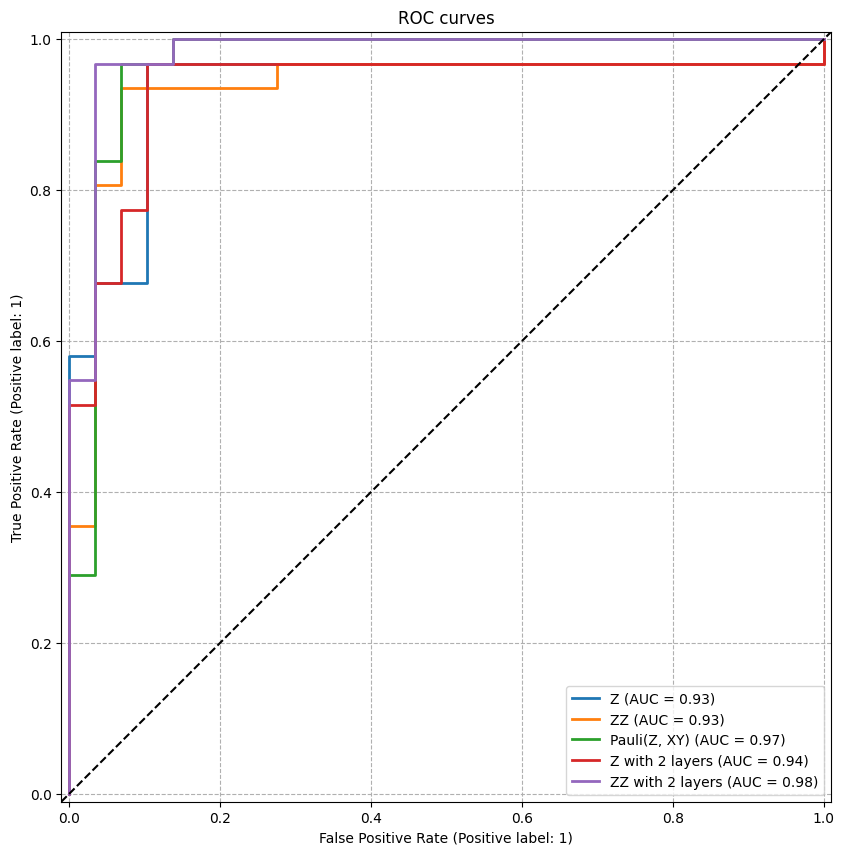

In [85]:
# plot the ROC curves
fig, ax_roc = plt.subplots(1, 1, figsize = (10, 10))

for feature_map_name, optimized_kernel in optimized_kernels.items():
    qsvc = QSVC(quantum_kernel = optimized_kernel)
    # Fit the QSVC
    qsvc.fit(X_train, y_train.values)
    RocCurveDisplay.from_estimator(qsvc, X_test, y_test, ax = ax_roc, name = feature_map_name, lw = 2)

ax_roc.set_title("ROC curves")
ax_roc.grid(linestyle = "--")
ax_roc.axline((0, 0), slope = 1, color = 'k', linestyle = '--')
plt.legend()
plt.show()

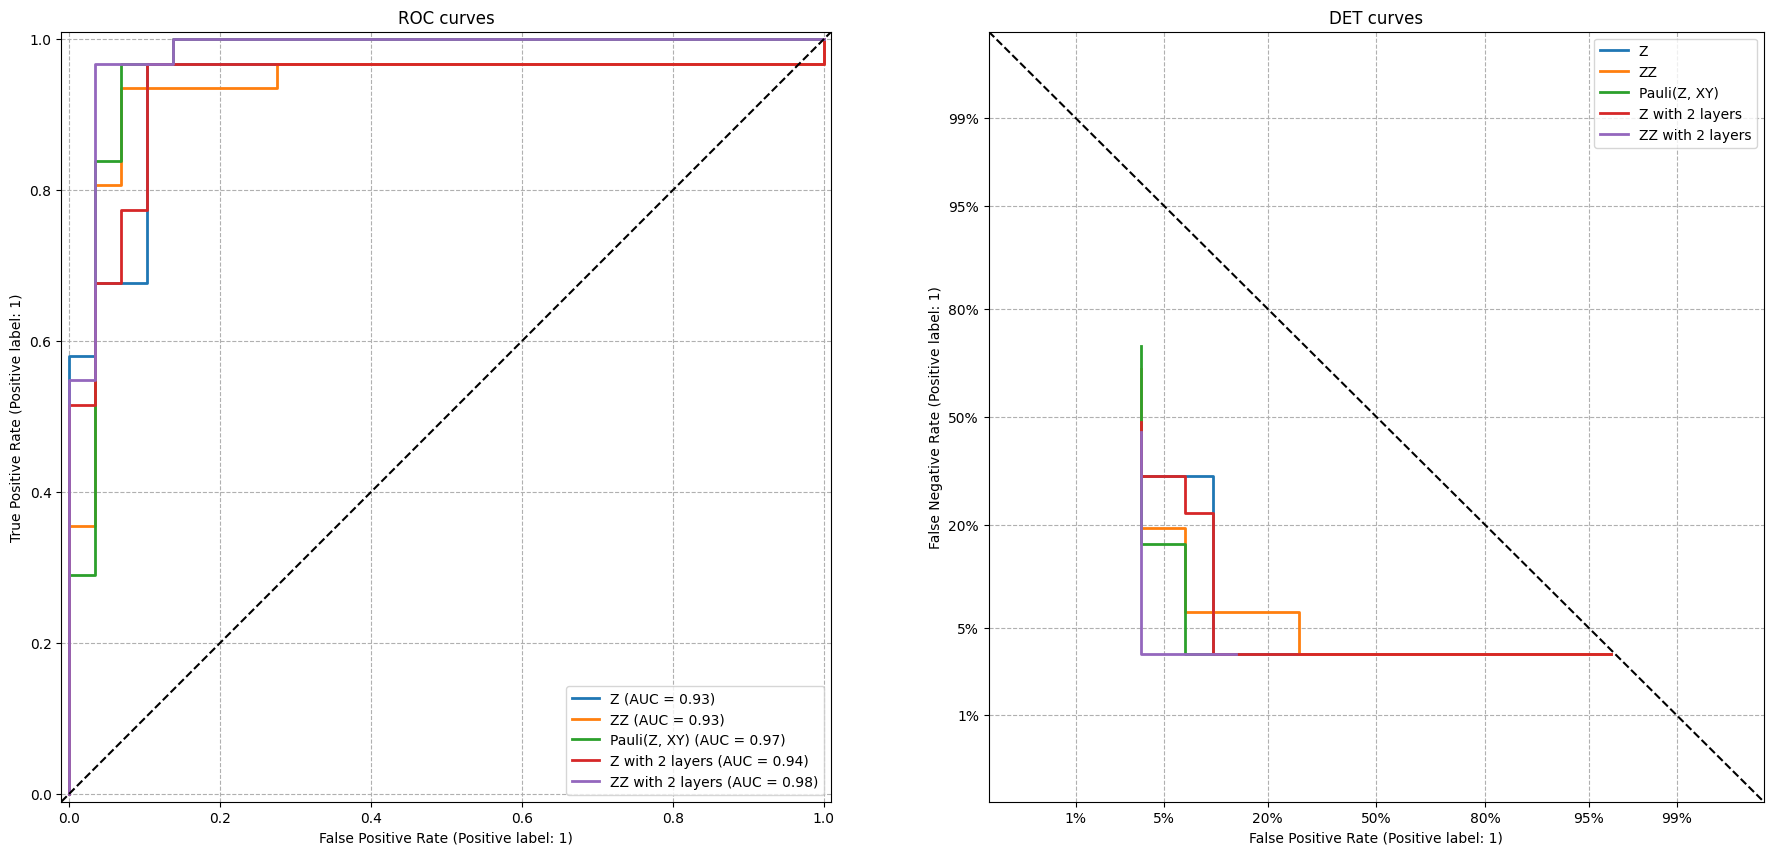

In [86]:
# plot the ROC and DET curves
fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize = (22, 10))

for feature_map_name, optimized_kernel in optimized_kernels.items():
    qsvc = QSVC(quantum_kernel = optimized_kernel)
    # Fit the QSVC
    qsvc.fit(X_train, y_train.values)
    RocCurveDisplay.from_estimator(qsvc, X_test, y_test.values, ax = ax_roc, name = feature_map_name, lw = 2)
    DetCurveDisplay.from_estimator(qsvc, X_test, y_test.values, ax = ax_det, name = feature_map_name, lw = 2)

ax_roc.set_title("ROC curves")
ax_det.set_title("DET curves")
ax_roc.grid(linestyle = "--")
ax_det.grid(linestyle = "--")
ax_roc.axline((0, 0), slope = 1, color = 'k', linestyle = '--')
ax_det.axline((0, 0), slope = -1, color = 'k', linestyle = '--')
plt.legend()
plt.show()

#### RealAmplitueds quantum circuit as parametric ansatz

Let us now try to consider increasingly complex parametric quantum circuits (i.e. with more parameters, and with more entanglement configurations) in order to see whether or not this represents a benefit in terms of the scores used to evaluate the classification. In the following simulation, the *RealAmplitudes* quantum circuit (which is already implemented in a qiskit module) is used as ansatz, and combined with the feature maps. 

Trainable parameters: ParameterView([ParameterVectorElement(θ[0]), ParameterVectorElement(θ[1]), ParameterVectorElement(θ[2]), ParameterVectorElement(θ[3]), ParameterVectorElement(θ[4]), ParameterVectorElement(θ[5]), ParameterVectorElement(θ[6]), ParameterVectorElement(θ[7])])


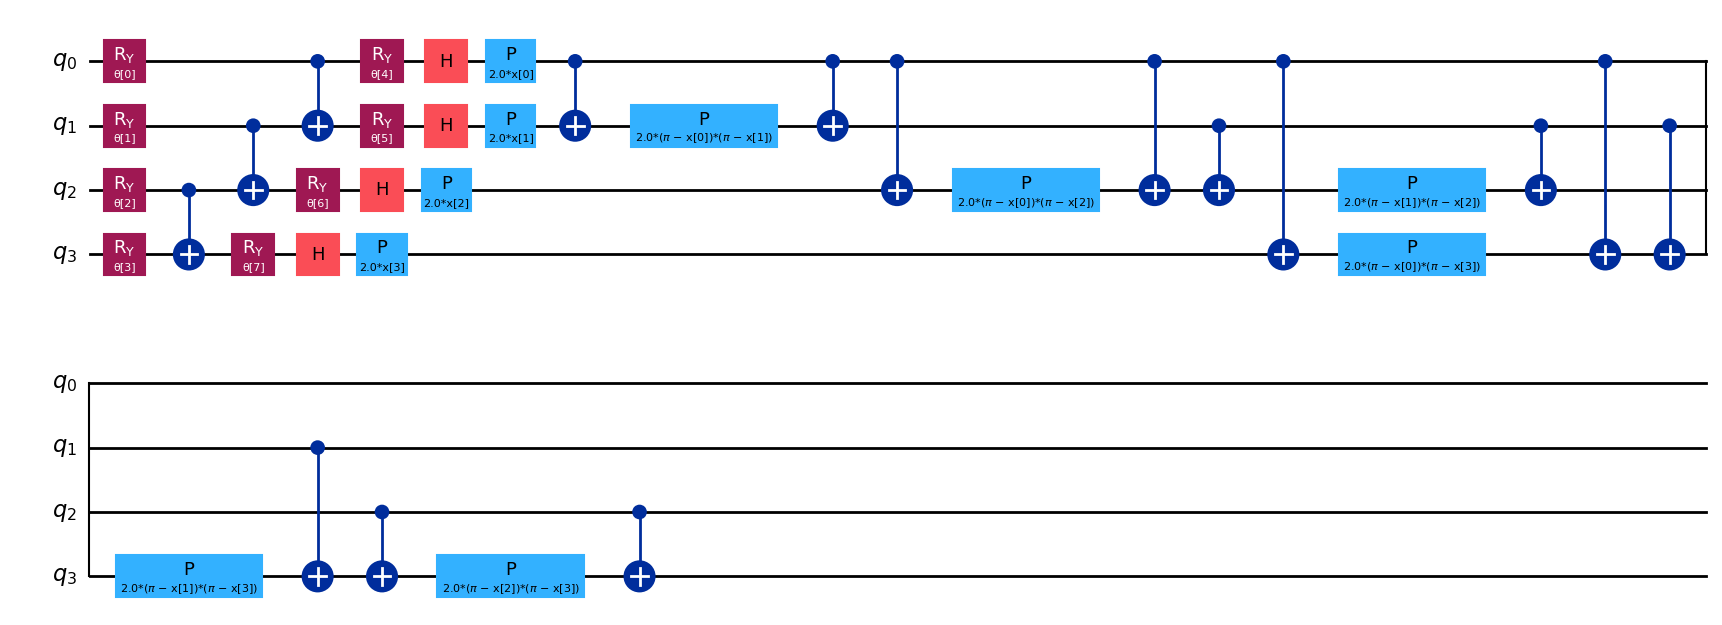

In [87]:
# set up the RealAmplitudes quantum circuit as ansatz layer
ansatz_layer = RealAmplitudes(num_qubits = num_features, reps = 1, parameter_prefix = "θ")
# initialize the parameters' vector to optimize
training_params = ansatz_layer.parameters
# Create the trainable feature maps, composed of two circuits: 
# the ansatz and the previous feature map
Z_param   = ansatz_layer.compose(Z)
ZZ_param  = ansatz_layer.compose(ZZ)
P_param   = ansatz_layer.compose(P)
Z2_param  = ansatz_layer.compose(Z2)
ZZ2_param = ansatz_layer.compose(ZZ2)

parametric_feature_map_dict = {'Z': Z_param, 'ZZ': ZZ_param, 'Pauli(Z, XY)': P_param, 'Z with 2 layers': Z2_param, 'ZZ with 2 layers': ZZ2_param}

#print(circuit_drawer(ansatz_layer.decompose()))
print(f"Trainable parameters: {training_params}")
ZZ_param.decompose().draw(output='mpl')

The steps and the code are identical to the previous cases

In [88]:
# local run
sampler = Sampler()
fidelity = ComputeUncompute(sampler = sampler)

optimized_kernels = {}
callback_data = []
qkt_callback = QKTCallback()
optimizer = SPSA(maxiter = 20, callback = qkt_callback.callback, learning_rate = 0.02, perturbation = 0.02)
#optimizer = COBYLA(maxiter = 20)

for feature_map_name, feature_map in parametric_feature_map_dict.items():
    quantum_kernel = TrainableFidelityQuantumKernel(fidelity = fidelity, feature_map = feature_map, training_parameters = training_params)
    qkt = QuantumKernelTrainer(
        quantum_kernel = quantum_kernel, loss = "svc_loss", optimizer = optimizer
    )
    # Train the kernel
    qkt_results = qkt.fit(X_train, y_train.values)
    optimized_kernels[feature_map_name] = qkt_results.quantum_kernel
    callback_data.append(qkt_callback.get_callback_data())
    qkt_callback.clear_callback_data()

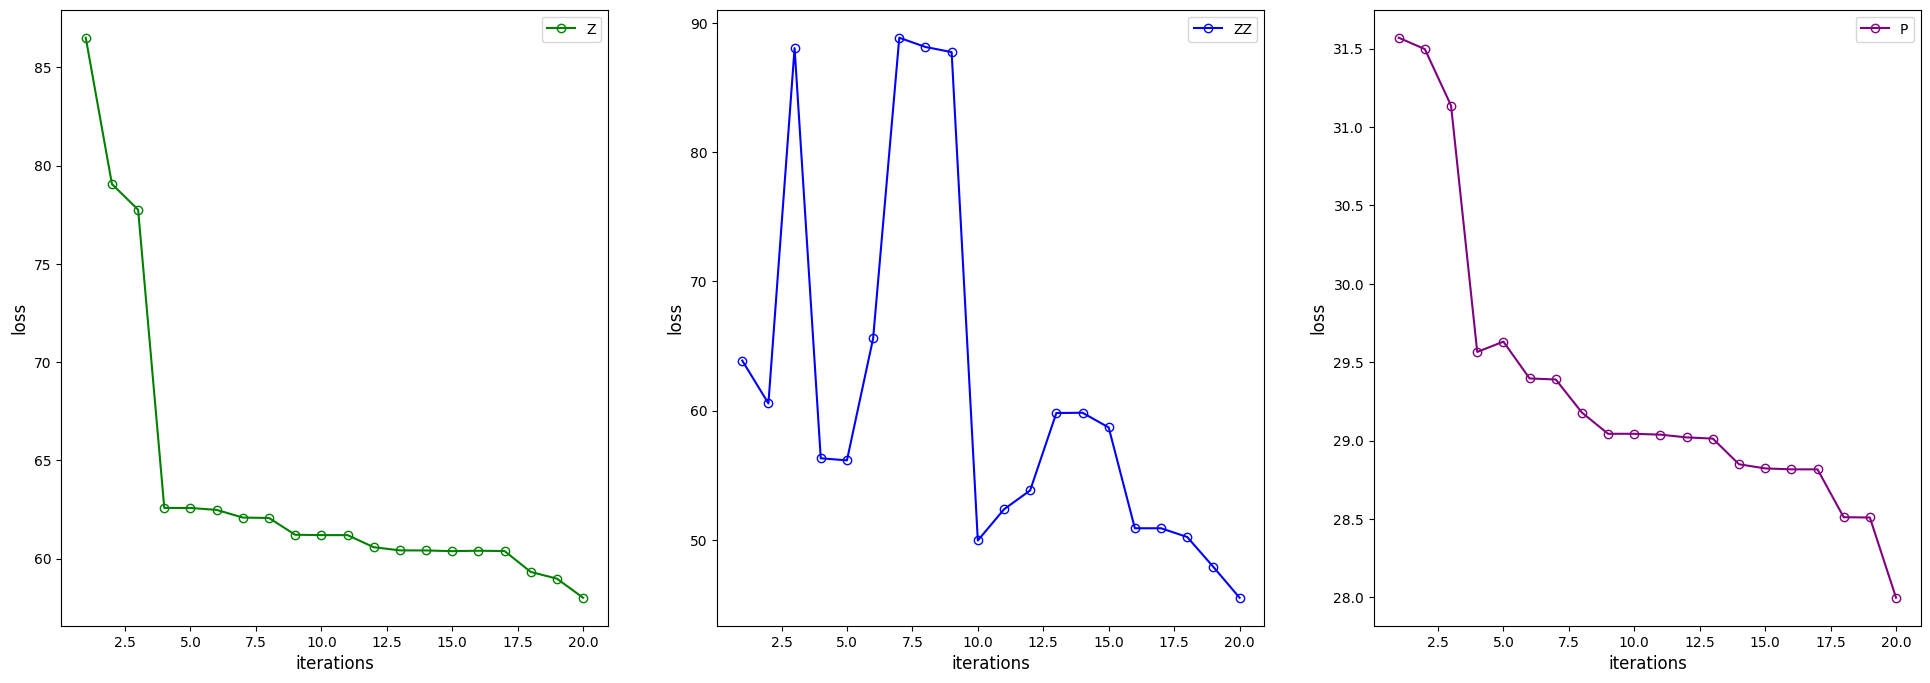

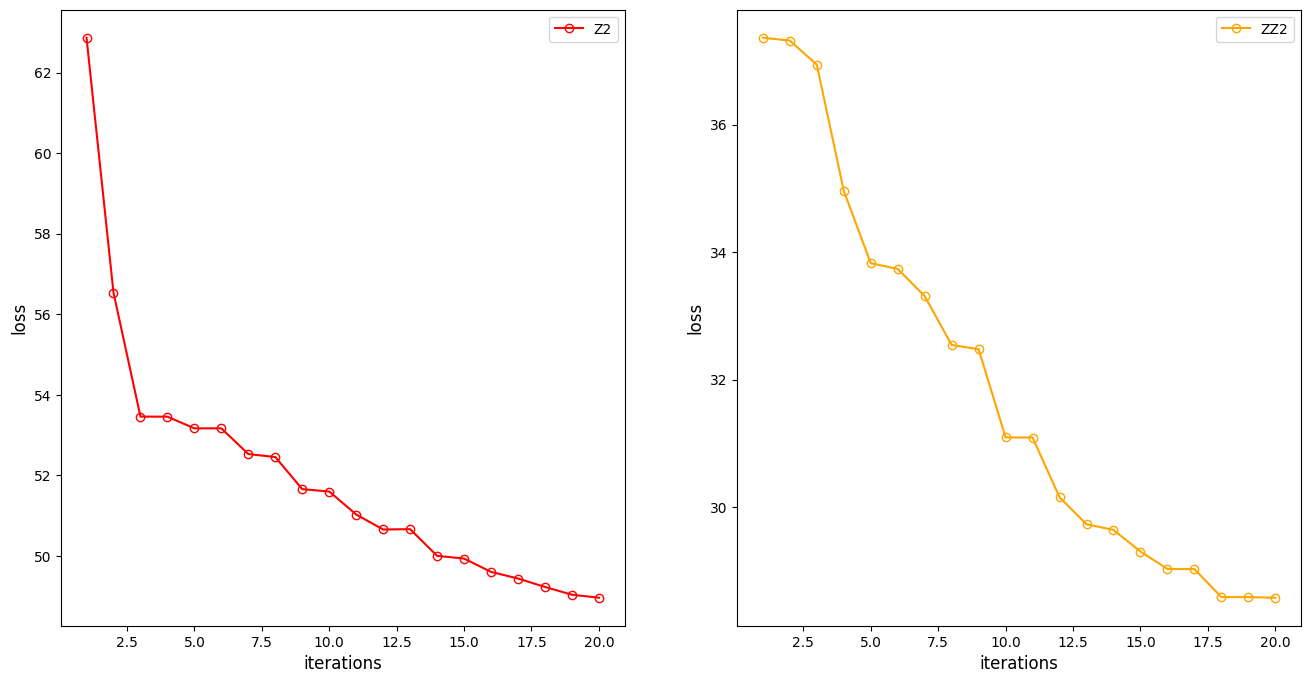

In [89]:
# visualize the training process for all the feature maps

fig = plt.figure(figsize=(24,8))
plt.subplot(131)
plt.plot([i + 1 for i in range(len(callback_data[0][0]))], np.array(callback_data[0][2]), marker = 'o', mfc = 'none', color = 'green', label = 'Z')
plt.xlabel("iterations", fontsize = 12)
plt.ylabel("loss", fontsize = 12)
plt.legend()
plt.subplot(132)
plt.plot([i + 1 for i in range(len(callback_data[1][0]))], np.array(callback_data[1][2]), marker = 'o', mfc = 'none', color = 'blue', label = 'ZZ')
plt.xlabel("iterations", fontsize = 12)
plt.ylabel("loss", fontsize = 12)
plt.legend()
plt.subplot(133)
plt.plot([i + 1 for i in range(len(callback_data[2][0]))], np.array(callback_data[2][2]), marker = 'o', mfc = 'none', color = 'purple', label = 'P')
plt.xlabel("iterations", fontsize = 12)
plt.ylabel("loss", fontsize = 12)
plt.legend()
plt.show()

fig = plt.figure(figsize=(16,8))
plt.subplot(121)
plt.plot([i + 1 for i in range(len(callback_data[3][0]))], np.array(callback_data[3][2]), marker = 'o', mfc = 'none', color = 'red', label = 'Z2')
plt.xlabel("iterations", fontsize = 12)
plt.ylabel("loss", fontsize = 12)
plt.legend()
plt.subplot(122)
plt.plot([i + 1 for i in range(len(callback_data[4][0]))], np.array(callback_data[4][2]), marker = 'o', mfc = 'none', color = 'orange', label = 'ZZ2')
plt.xlabel("iterations", fontsize = 12)
plt.ylabel("loss", fontsize = 12)
plt.legend()

In [90]:
for feature_map_name, optimized_kernel in optimized_kernels.items():
    qsvc = QSVC(quantum_kernel = optimized_kernel)
    # Fit the QSVC
    qsvc.fit(X_train, y_train.values)
    print(f"Evaluating performance for {feature_map_name} Feature Map:\n")
    # Perform predictions and evaluate performance metrics
    evaluate_with_feature_map(qsvc, X_train, y_train.values, X_test, y_test.values, feature_map_name)

Evaluating performance for Z Feature Map:

Classification Report for Z Feature Map (Train Set):

              precision    recall  f1-score   support

           0       0.86      0.89      0.88        71
           1       0.88      0.86      0.87        69

    accuracy                           0.87       140
   macro avg       0.87      0.87      0.87       140
weighted avg       0.87      0.87      0.87       140

Confusion Matrix for Train Set:
[[63  8]
 [10 59]]


Classification Report for Z Feature Map (Test Set):

              precision    recall  f1-score   support

           0       0.87      0.90      0.88        29
           1       0.90      0.87      0.89        31

    accuracy                           0.88        60
   macro avg       0.88      0.88      0.88        60
weighted avg       0.88      0.88      0.88        60

Confusion Matrix for Test Set:
[[26  3]
 [ 4 27]]
ROC AUC Score for Z Feature Map (Test Set):
0.9333
Evaluating performance for ZZ Feature Map:

We can summarize the results below, according to the ROC AUC score and the weighted average accuracy score:

|feature map|ROC AUC|Accuracy|
|:---:|:---|:---| 
|Z with 1 layer |0.9333|0.88|
|ZZ with 1 layer|0.9244|0.83|
|P(Z, XY) 1 layer|**0.9700**|**0.97**|
|Z with 2 layers|**0.9344**|**0.90**|
|ZZ with 2 layers|**0.9644**|**0.90**|

In this case there is a slight improvement in the scores' values (compared to the case of non-optimized kernels) for the last two feature maps (Z and ZZ with two layers), while there is an overall worsening of the scores for the Z and ZZ feature maps with single layer. The best feature map with RealAmplitudes ansatz turns out to be definitely the Pauli feature map (which records the highest score values ​​ever), while the worst is the single layer ZZ. The reason for this last thing may be due to the unstable trend of the loss function, a sign that even lower learning rates could be taken for this feature map. For the other loss functions, it seems that they have not reached a saturation level, and the trend is even decreasing at the end of the optimization process. This fact suggests that we can boost the optimization, adding more iterations of the optimizer

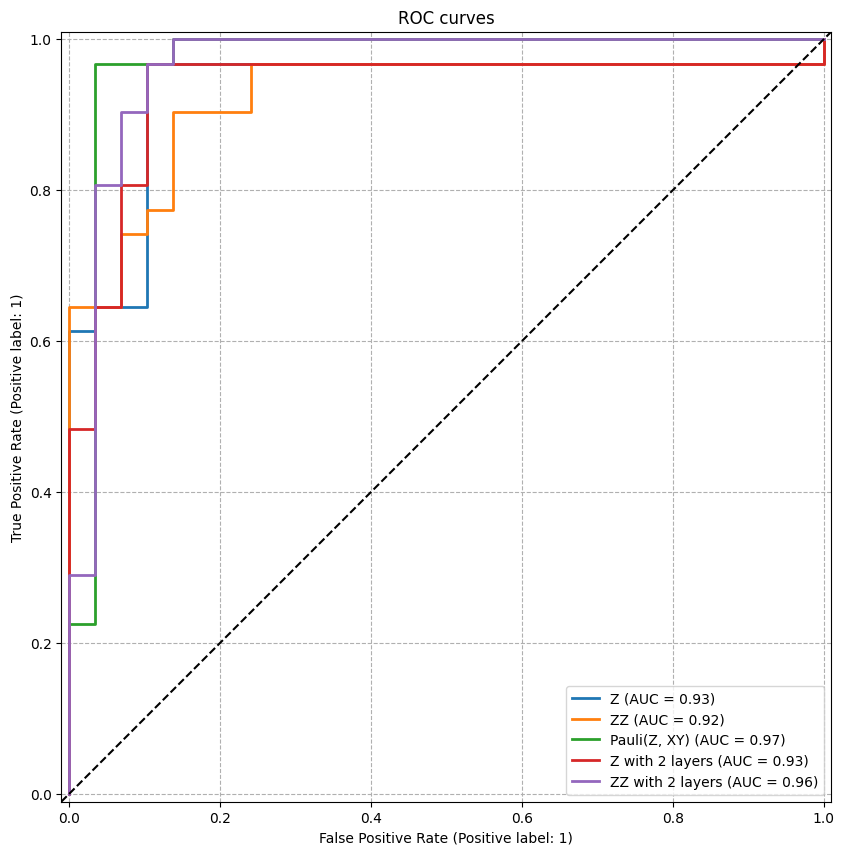

In [91]:
# plot the ROC curves
fig, ax_roc = plt.subplots(1, 1, figsize = (10, 10))

for feature_map_name, optimized_kernel in optimized_kernels.items():
    qsvc = QSVC(quantum_kernel = optimized_kernel)
    # Fit the QSVC
    qsvc.fit(X_train, y_train.values)
    RocCurveDisplay.from_estimator(qsvc, X_test, y_test, ax = ax_roc, name = feature_map_name, lw = 2)

ax_roc.set_title("ROC curves")
ax_roc.grid(linestyle = "--")
ax_roc.axline((0, 0), slope = 1, color = 'k', linestyle = '--')
plt.legend()
plt.show()

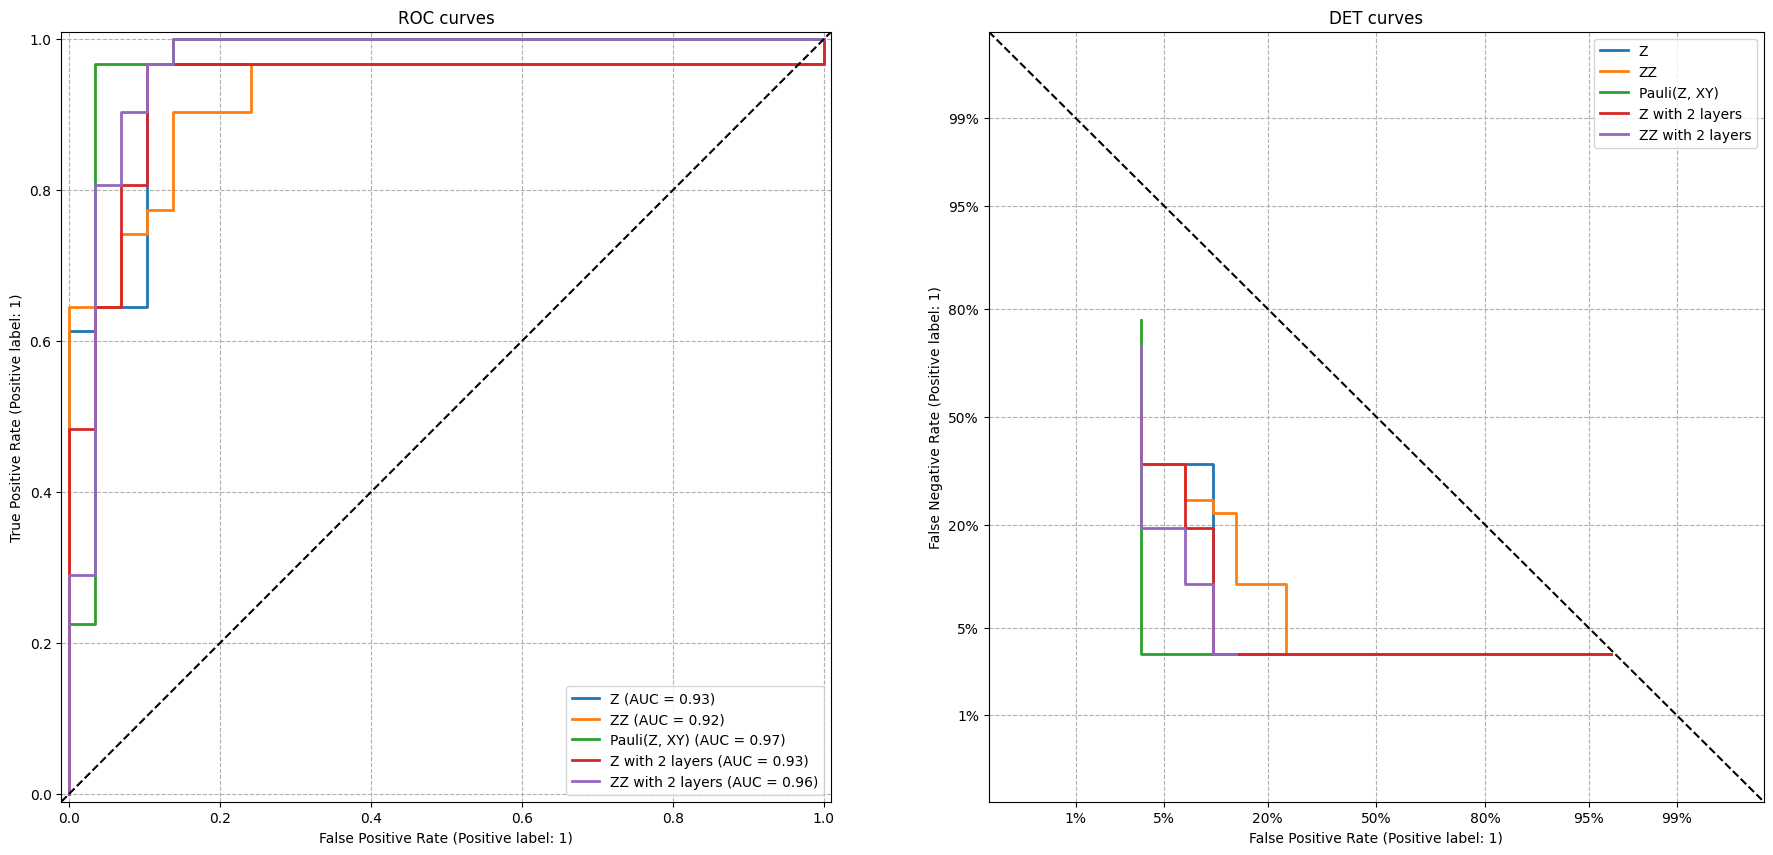

In [92]:
# plot the ROC and DET curves
fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize = (22, 10))

for feature_map_name, optimized_kernel in optimized_kernels.items():
    qsvc = QSVC(quantum_kernel = optimized_kernel)
    # Fit the QSVC
    qsvc.fit(X_train, y_train.values)
    RocCurveDisplay.from_estimator(qsvc, X_test, y_test.values, ax = ax_roc, name = feature_map_name, lw = 2)
    DetCurveDisplay.from_estimator(qsvc, X_test, y_test.values, ax = ax_det, name = feature_map_name, lw = 2)

ax_roc.set_title("ROC curves")
ax_det.set_title("DET curves")
ax_roc.grid(linestyle = "--")
ax_det.grid(linestyle = "--")
ax_roc.axline((0, 0), slope = 1, color = 'k', linestyle = '--')
ax_det.axline((0, 0), slope = -1, color = 'k', linestyle = '--')
plt.legend()
plt.show()

### Noise model for the single rotation layer with multiple parameters

The best parametric quantum circuit (so far) with the selected feature maps seems to be the single rotational layer with multiple parameters. So the next step is to implement the same model, and perform the same optimization process, but adding the noise to the simulation. The steps of the simulation are identical, the only change is the usage of a fake backend and the NoiseModel class from qiskit_aer

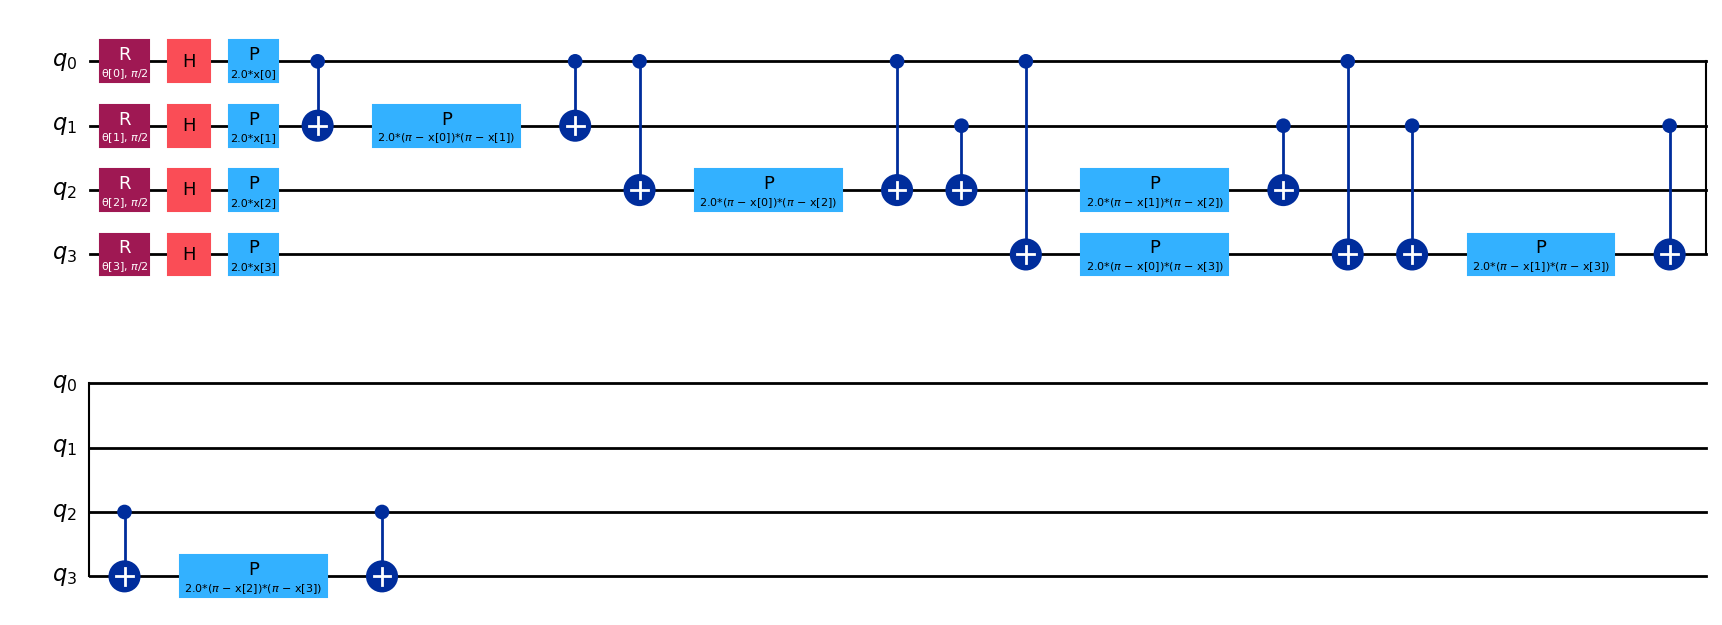

In [100]:
# create the feature maps
Z = ZFeatureMap(feature_dimension = num_features, reps = 1)
ZZ = ZZFeatureMap(feature_dimension = num_features, reps = 1)
P = PauliFeatureMap(feature_dimension = num_features, reps = 1, paulis = ['Z', 'XY'])
Z2 = ZFeatureMap(feature_dimension = num_features, reps = 2)
ZZ2 = ZZFeatureMap(feature_dimension = num_features, reps = 2)
# Create a parametrized layer to train
training_params = ParameterVector("θ", num_features)
ansatz_layer = QuantumCircuit(num_features)
for i in range(num_features):
    ansatz_layer.ry(training_params[i], i)
# Create the trainable feature maps, composed of two circuits: 
# the ansatz and the previous feature map
Z_param   = ansatz_layer.compose(Z)
ZZ_param  = ansatz_layer.compose(ZZ)
P_param   = ansatz_layer.compose(P)
Z2_param  = ansatz_layer.compose(Z2)
ZZ2_param = ansatz_layer.compose(ZZ2)

parametric_feature_map_dict = {'Z': Z_param, 'ZZ': ZZ_param, 'Pauli(Z, XY)': P_param, 'Z with 2 layers': Z2_param, 'ZZ with 2 layers': ZZ2_param}

#print(circuit_drawer(ansatz_layer.decompose()))
#print(f"Trainable parameters: {training_params}")
ZZ_param.decompose().draw(output='mpl')

In [101]:
from qiskit.providers.fake_provider import Fake20QV1
from qiskit_aer.noise import NoiseModel
from qiskit_aer.primitives import Sampler as aerSampler

#service = IBMR.QiskitRuntimeService(channel = "ibm_quantum")#, token = "88eeb7f45dcf7770dc57b658d3a7777feba57f28d40e8790d737aea341704a16da5e7163756b82a020919f20b6ccf8c300efed8abb45b2a5a531dcbc7253e51f")
#backend = service.get_backend("ibmq_qasm_simulator")

# set the fake backend
fake_backend = Fake20QV1()
noise_model = NoiseModel.from_backend(fake_backend)
# set the options to include the noise model, the optimization level and the resilience level
#options = IBMR.Options()
options = Options()

options.simulator = {
    "noise_model": noise_model,
    "basis_gates": fake_backend.configuration().basis_gates,
    "coupling_map": fake_backend.configuration().coupling_map,
    "seed_simulator": 42
}
# set the optimization level to 0, in order to avoid error suppression
options.optimization_level = 0

#sampler = IBMR.Sampler(options = options)
sampler = Sampler(options = options)

optimized_kernels = {}
callback_data = []

# run the model with noise:
#with IBMR.Session(service = service, backend = backend):
#sampler = IBMR.Sampler(options = options)
fidelity = ComputeUncompute(sampler = sampler)

qkt_callback = QKTCallback()
#optimizer = SPSA(maxiter = 20, callback = qkt_callback.callback, learning_rate = 0.05, perturbation = 0.05)
#optimizer = COBYLA(maxiter = 20)

for feature_map_name, feature_map in parametric_feature_map_dict.items():
    quantum_kernel = TrainableFidelityQuantumKernel(fidelity = fidelity, feature_map = feature_map, training_parameters = training_params)
    if (feature_map_name == 'ZZ'):
        optimizer = SPSA(maxiter = 20, callback = qkt_callback.callback, learning_rate = 0.01, perturbation = 0.01)
    elif (feature_map_name == 'Z'):
        optimizer = SPSA(maxiter = 20, callback = qkt_callback.callback, learning_rate = 0.04, perturbation = 0.04)
    else:
        optimizer = SPSA(maxiter = 20, callback = qkt_callback.callback, learning_rate = 0.05, perturbation = 0.05)
    qkt = QuantumKernelTrainer( quantum_kernel = quantum_kernel, loss = "svc_loss", optimizer = optimizer)
    # Train the kernel
    qkt_results = qkt.fit(X_train, y_train.values)
    optimized_kernels[feature_map_name] = qkt_results.quantum_kernel
    callback_data.append(qkt_callback.get_callback_data())
    qkt_callback.clear_callback_data()

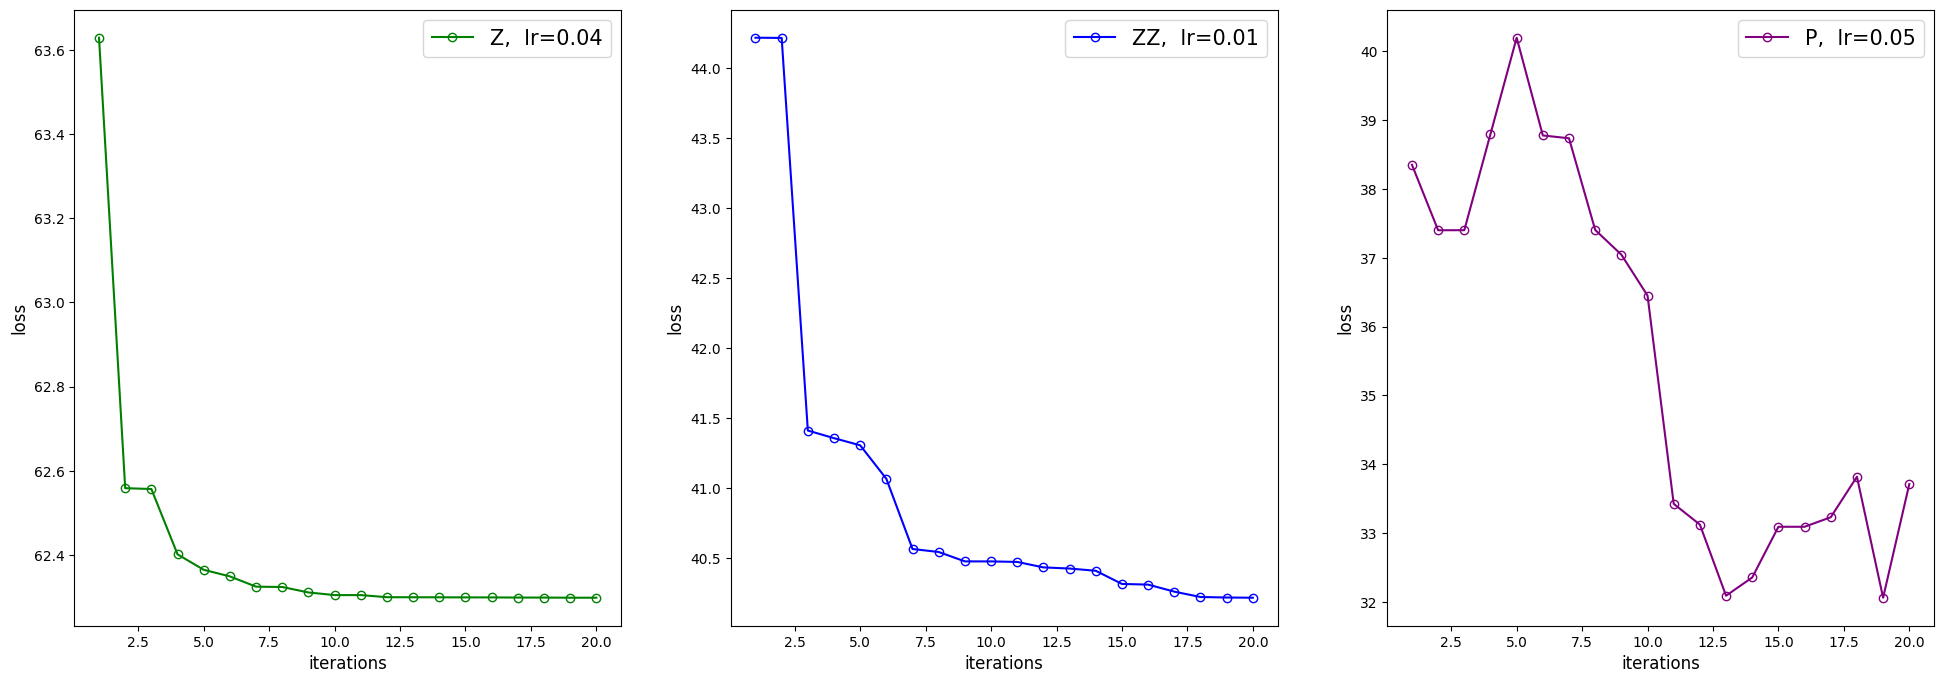

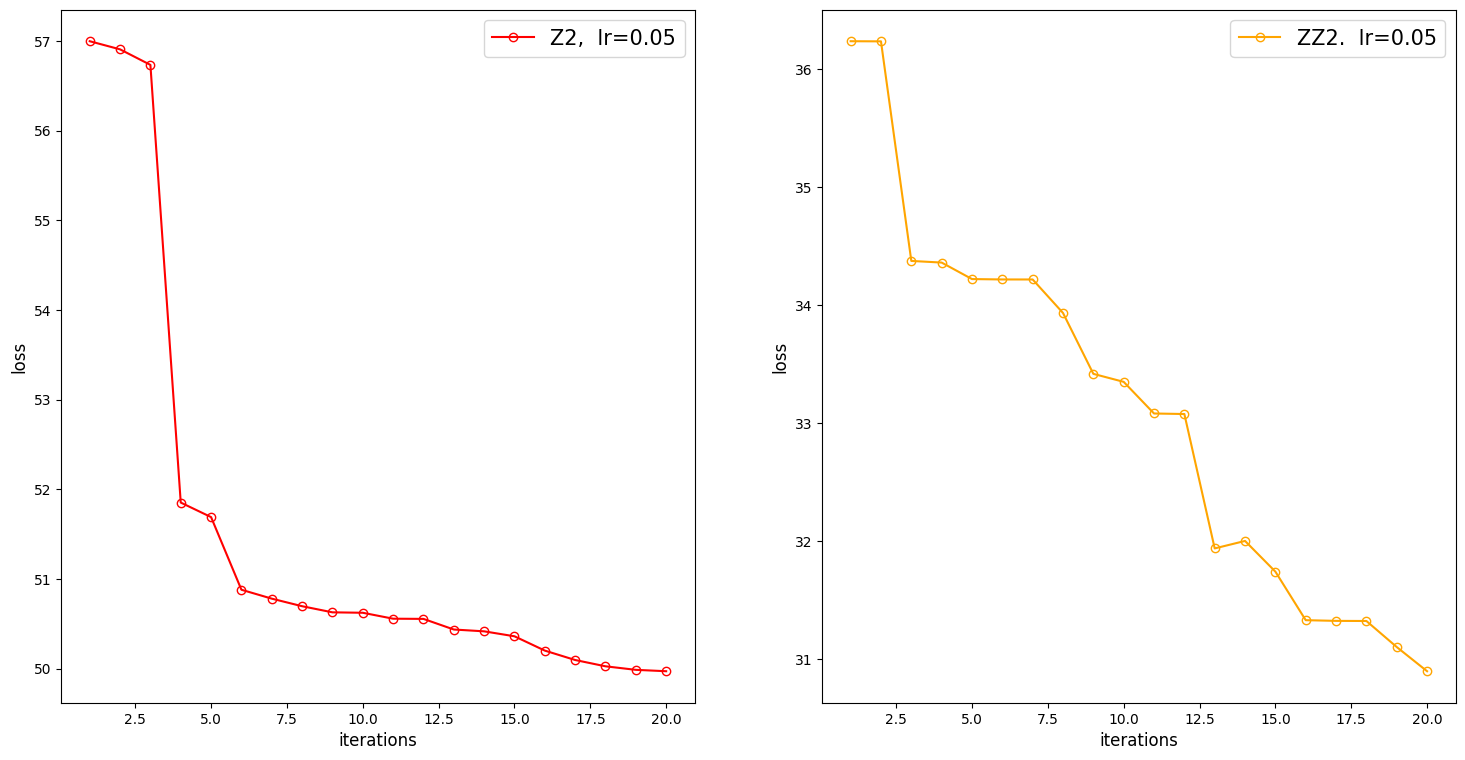

In [108]:
fig = plt.figure(figsize=(24,8))
plt.subplot(131)
plt.plot([i + 1 for i in range(len(callback_data[0][0]))], np.array(callback_data[0][2]), marker = 'o', mfc = 'none', color = 'green', label = 'Z,  lr=0.04')
plt.xlabel("iterations", fontsize = 12)
plt.ylabel("loss", fontsize = 12)
plt.legend(fontsize = 15)
plt.subplot(132)
plt.plot([i + 1 for i in range(len(callback_data[1][0]))], np.array(callback_data[1][2]), marker = 'o', mfc = 'none', color = 'blue', label = 'ZZ,  lr=0.01')
plt.xlabel("iterations", fontsize = 12)
plt.ylabel("loss", fontsize = 12)
plt.legend(fontsize = 15)
plt.subplot(133)
plt.plot([i + 1 for i in range(len(callback_data[2][0]))], np.array(callback_data[2][2]), marker = 'o', mfc = 'none', color = 'purple', label = 'P,  lr=0.05')
plt.xlabel("iterations", fontsize = 12)
plt.ylabel("loss", fontsize = 12)
plt.legend(fontsize = 15)
plt.show()

fig = plt.figure(figsize=(18,9))
plt.subplot(121)
plt.plot([i + 1 for i in range(len(callback_data[3][0]))], np.array(callback_data[3][2]), marker = 'o', mfc = 'none', color = 'red', label = 'Z2,  lr=0.05')
plt.xlabel("iterations", fontsize = 12)
plt.ylabel("loss", fontsize = 12)
plt.legend(fontsize = 15)
plt.subplot(122)
plt.plot([i + 1 for i in range(len(callback_data[4][0]))], np.array(callback_data[4][2]), marker = 'o', mfc = 'none', color = 'orange', label = 'ZZ2.  lr=0.05')
plt.xlabel("iterations", fontsize = 12)
plt.ylabel("loss", fontsize = 12)
plt.legend(fontsize = 15)

In [109]:
for feature_map_name, optimized_kernel in optimized_kernels.items():
    qsvc = QSVC(quantum_kernel = optimized_kernel)
    # Fit the QSVC
    qsvc.fit(X_train, y_train)
    print(f"Evaluating performance for {feature_map_name} Feature Map:\n")
    # Perform predictions and evaluate performance metrics
    evaluate_with_feature_map(qsvc, X_train, y_train, X_test, y_test, feature_map_name)

Evaluating performance for Z Feature Map:

Classification Report for Z Feature Map (Train Set):

              precision    recall  f1-score   support

           0       0.84      0.89      0.86        71
           1       0.88      0.83      0.85        69

    accuracy                           0.86       140
   macro avg       0.86      0.86      0.86       140
weighted avg       0.86      0.86      0.86       140

Confusion Matrix for Train Set:
[[63  8]
 [12 57]]


Classification Report for Z Feature Map (Test Set):

              precision    recall  f1-score   support

           0       0.84      0.90      0.87        29
           1       0.90      0.84      0.87        31

    accuracy                           0.87        60
   macro avg       0.87      0.87      0.87        60
weighted avg       0.87      0.87      0.87        60

Confusion Matrix for Test Set:
[[26  3]
 [ 5 26]]
ROC AUC Score for Z Feature Map (Test Set):
0.9366
Evaluating performance for ZZ Feature Map:

We can summarize the results below, according to the ROC AUC score and the weighted average accuracy score:

|feature map|ROC AUC|Accuracy|
|:---:|:---|:---| 
|Z with 1 layer |0.9366|0.87|
|ZZ with 1 layer|0.9344|**0.93**|
|P(Z, XY) 1 layer|**0.9555**|0.92|
|Z with 2 layers|**0.9366**|0.88|
|ZZ with 2 layers|**0.9522**|0.88|

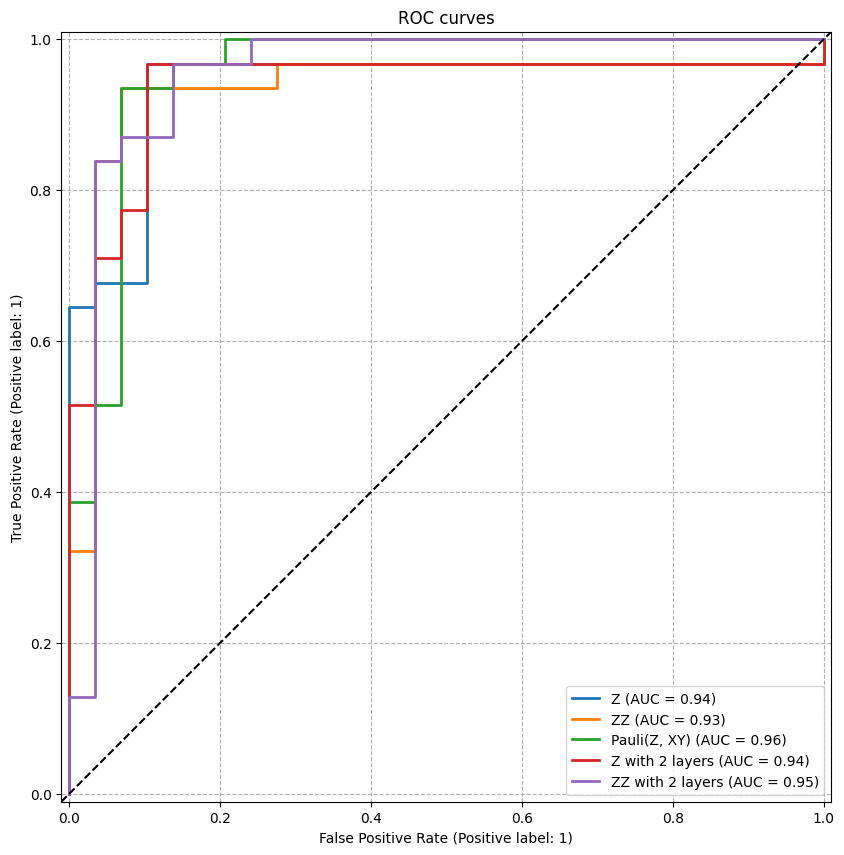

In [110]:
# plot ROC curve
fig, ax_roc = plt.subplots(1, 1, figsize = (10, 10))

for feature_map_name, optimized_kernel in optimized_kernels.items():
    qsvc = QSVC(quantum_kernel = optimized_kernel)
    # Fit the QSVC
    qsvc.fit(X_train, y_train.values)
    RocCurveDisplay.from_estimator(qsvc, X_test, y_test.values, ax = ax_roc, name = feature_map_name, lw = 2)

ax_roc.set_title("ROC curves")
ax_roc.grid(linestyle = "--")
ax_roc.axline((0, 0), slope = 1, color = 'k', linestyle = '--')
plt.legend()
plt.show()

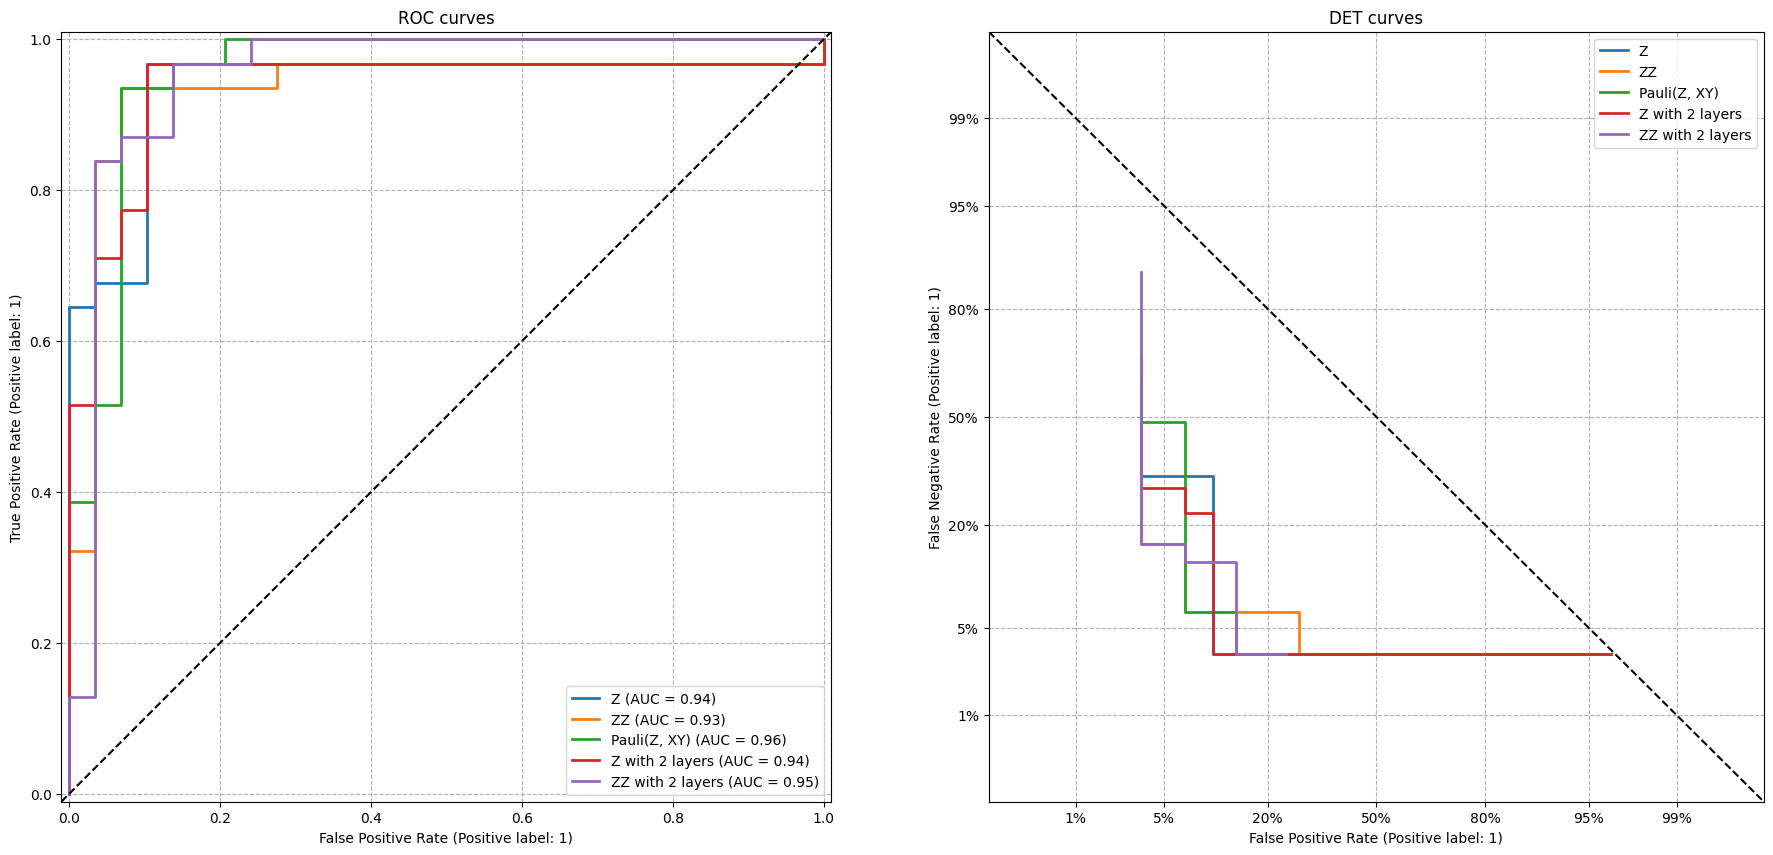

In [111]:
# plot ROC DET curves
fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize = (22, 10))

for feature_map_name, optimized_kernel in optimized_kernels.items():
    qsvc = QSVC(quantum_kernel = optimized_kernel)
    # Fit the QSVC
    qsvc.fit(X_train, y_train.values)
    RocCurveDisplay.from_estimator(qsvc, X_test, y_test.values, ax = ax_roc, name = feature_map_name, lw = 2)
    DetCurveDisplay.from_estimator(qsvc, X_test, y_test.values, ax = ax_det, name = feature_map_name, lw = 2)

ax_roc.set_title("ROC curves")
ax_det.set_title("DET curves")
ax_roc.grid(linestyle = "--")
ax_det.grid(linestyle = "--")
ax_roc.axline((0, 0), slope = 1, color = 'k', linestyle = '--')
ax_det.axline((0, 0), slope = -1, color = 'k', linestyle = '--')
plt.legend()
plt.show()

In [ ]:
#from qiskit_aer import AerSimulator
#from qiskit.primitives import BackendSampler
#
#fake_backend = Fake20QV1()
#aer_simulator = AerSimulator.from_backend(fake_backend)
#
#aer_simulator.shots = 1000
#aer_simulator.optimization_level = 0
#
#sampler = BackendSampler(backend = aer_simulator)
#fidelity = ComputeUncompute(sampler = sampler)
#
#optimized_kernels = {}
#callback_data = []
#
#qkt_callback = QKTCallback()
##optimizer = SPSA(maxiter = 20, callback = qkt_callback.callback, learning_rate = 0.05, perturbation = 0.05)
##optimizer = COBYLA(maxiter = 20)
#
#for feature_map_name, feature_map in parametric_feature_map_dict.items():
#    quantum_kernel = TrainableFidelityQuantumKernel(fidelity = fidelity, feature_map = feature_map, training_parameters = training_params)
#    if (feature_map_name == 'ZZ'):
#        optimizer = SPSA(maxiter = 20, callback = qkt_callback.callback, learning_rate = 0.01, perturbation = 0.01)
#    elif (feature_map_name == 'Z'):
#        optimizer = SPSA(maxiter = 20, callback = qkt_callback.callback, learning_rate = 0.04, perturbation = 0.04)
#    else:
#        optimizer = SPSA(maxiter = 20, callback = qkt_callback.callback, learning_rate = 0.05, perturbation = 0.05)
#    qkt = QuantumKernelTrainer( quantum_kernel = quantum_kernel, loss = "svc_loss", optimizer = optimizer)
#    # Train the kernel
#    qkt_results = qkt.fit(X_train, y_train.values)
#    optimized_kernels[feature_map_name] = qkt_results.quantum_kernel
#    callback_data.append(qkt_callback.get_callback_data())
#    qkt_callback.clear_callback_data()

All the results obtained can be summarized with the following heatmap:

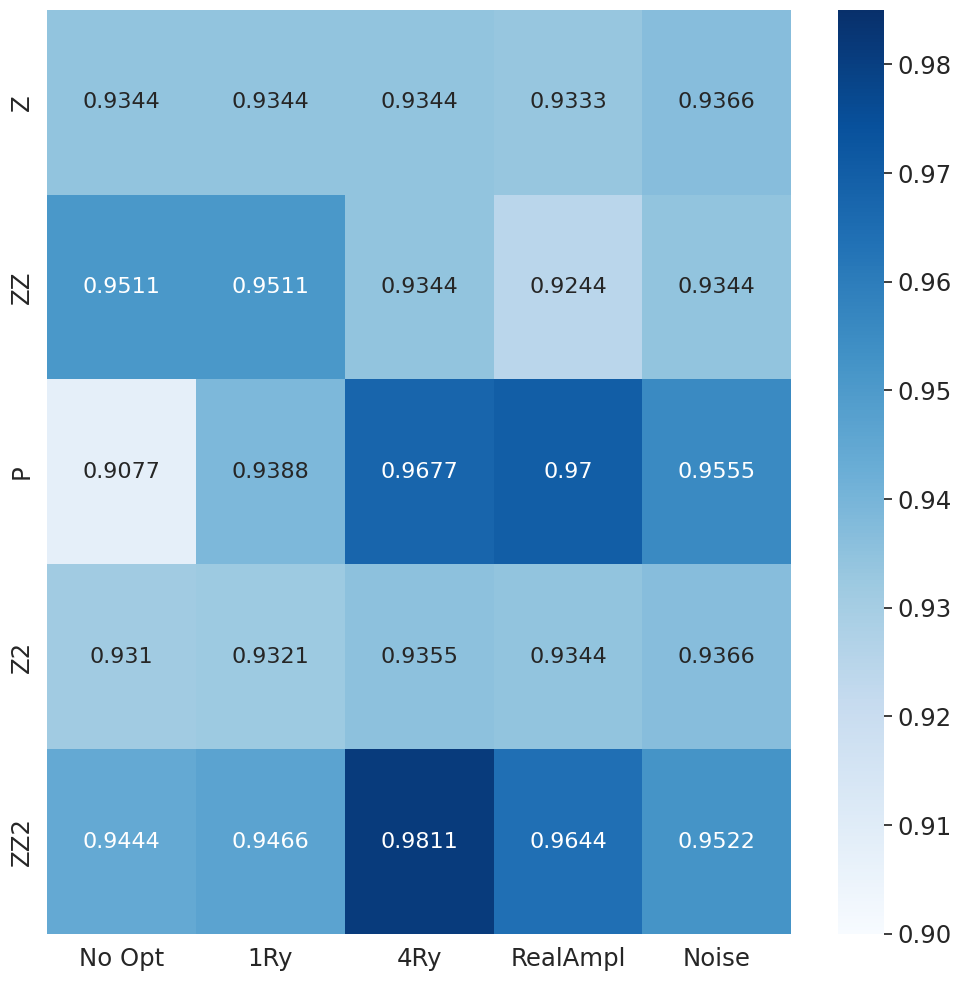

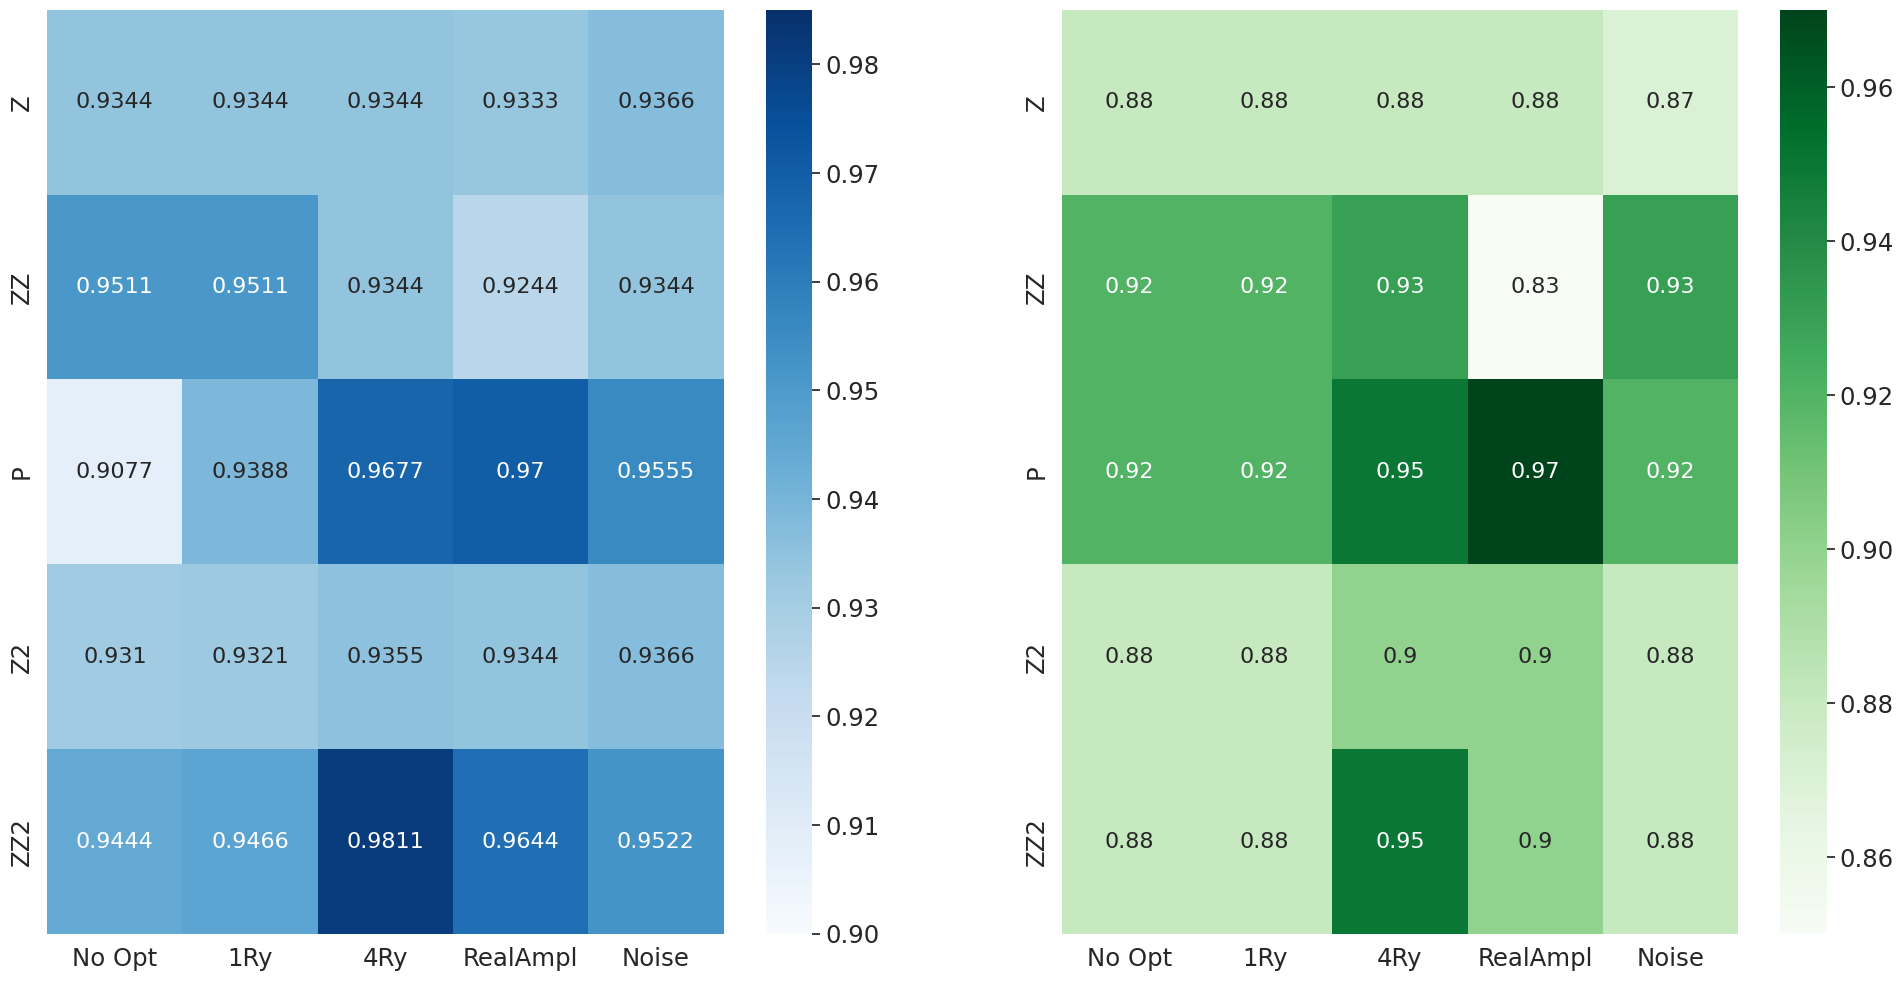

In [140]:
import seaborn as sns 
sns.set(font_scale = 1.6)

final_array_ROC = np.array(([0.9344, 0.9511, 0.9077, 0.9310, 0.9444],
                            [0.9344, 0.9511, 0.9388, 0.9321, 0.9466],
                            [0.9344, 0.9344, 0.9677, 0.9355, 0.9811],
                            [0.9333, 0.9244, 0.9700, 0.9344, 0.9644],
                            [0.9366, 0.9344, 0.9555, 0.9366, 0.9522])).reshape(5, 5)

final_array_ACC = np.array(([0.88, 0.92, 0.92, 0.88, 0.88],
                            [0.88, 0.92, 0.92, 0.88, 0.88],
                            [0.88, 0.93, 0.95, 0.90, 0.95],
                            [0.88, 0.83, 0.97, 0.90, 0.90],
                            [0.87, 0.93, 0.92, 0.88, 0.88])).reshape(5, 5)

# plot the final heatmap with all the results with the ROC AUC score
fig, ax1 = plt.subplots(1, 1, figsize = (12, 12))
sns.heatmap(final_array_ROC.T, 
            xticklabels = ["No Opt", "1Ry", "4Ry", "RealAmpl", "Noise"], 
            yticklabels = ["Z", "ZZ", "P", "Z2", "ZZ2"], 
            annot = True, 
            ax = ax1, fmt=".4g", cmap = "Blues", annot_kws={"fontsize":16}, 
            vmin = 0.90, vmax = 0.985
)
plt.show()

# plot the final heatmap with all the results with both the ROC AUC score and the average accuracy
fig, [ax1, ax2] = plt.subplots(1, 2, figsize = (24, 12))
sns.heatmap(final_array_ROC.T, 
            xticklabels = ["No Opt", "1Ry", "4Ry", "RealAmpl", "Noise"], 
            yticklabels = ["Z", "ZZ", "P", "Z2", "ZZ2"], 
            annot = True, 
            ax = ax1, fmt=".4g", cmap = "Blues", annot_kws={"fontsize":16}, 
            vmin = 0.90, vmax = 0.985
)
sns.heatmap(final_array_ACC.T, 
            xticklabels = ["No Opt", "1Ry", "4Ry", "RealAmpl", "Noise"], 
            yticklabels = ["Z", "ZZ", "P", "Z2", "ZZ2"], 
            annot = True, 
            ax = ax2, fmt=".4g", cmap = "Greens", annot_kws={"fontsize":16}, 
            vmin = 0.85, vmax = 0.97
)
plt.show()

## Quantum kernel methods for principal component analysis

The next section focuses on a Principal-Component-Analysis task using a kernel PCA algorithm (for example the kernelPCA module of sklearn). The aim is to calculate the kernel Gram matrix using both a classical kernel (such as a polynomial kernel) and a quantum kernel, encoding the data with a certain feature map (in the following case the ZZ with depth 2 was used). The usage of these two kernel matrices can transform the original space of features (only two features will be used) into a new space where they are more separable, and the classification task is easier. A simple classical classification algorithm (for example a linear classifier) ​​will then be used on these transformed features. The aim is to see if transforming the features using a quantum kernel provides better results than transforming them using a classical kernel, if the classification is performed by a simple classical classification algorithm, such as a linear classifier.

In [ ]:
from sklearn.decomposition import KernelPCA
from sklearn.linear_model import LogisticRegression

In [ ]:
# initialize the sampler and the fidelity parameter for the quantum kernel
sampler = Sampler()
fidelity = ComputeUncompute(sampler = sampler)

# initialize the feature map and the quantum kernel
# in this case we use only two features
ZZ2 = ZZFeatureMap(feature_dimension = 2, reps = 2)
#P = PauliFeatureMap(feature_dimension = num_features, reps = 1, paulis = ['Z', 'XY'])
quantum_pca_kernel = FidelityQuantumKernel(fidelity = fidelity, feature_map = ZZ2)

# evaluate kernel matrices for the training and test features
quantum_matrix_train = quantum_pca_kernel.evaluate(x_vec = X_train[:, 2:4])
quantum_matrix_test  = quantum_pca_kernel.evaluate(x_vec = X_test[:, 2:4], y_vec = X_train[:, 2:4])

In [ ]:
# compute a gaussian classical kernel and transform the feature according
classic_kernel_pca_rbf = KernelPCA(n_components = 2, kernel = "poly")
classic_kernel_pca_rbf.fit(X_train[:, 2:4])
X_train_rbf = classic_kernel_pca_rbf.transform(X_train[:, 2:4])
X_test_rbf  = classic_kernel_pca_rbf.transform(X_test[:, 2:4])

# compute a quantum kernel Gram matrix and transform the feature according
quantum_kernel_pca = KernelPCA(n_components = 2, kernel = "precomputed")
X_train_quantum = quantum_kernel_pca.fit_transform(quantum_matrix_train)
X_test_quantum  = quantum_kernel_pca.transform(quantum_matrix_test)

# train and score a classical model using the transformed features
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train_rbf, y_train)
logistic_score = logistic_regression.score(X_test_rbf, y_test)
print(f"Logistic regression score: {logistic_score}")

logistic_regression = LogisticRegression()
logistic_regression.fit(X_train_quantum, y_train)
logistic_score = logistic_regression.score(X_test_quantum, y_test)
print(f"Logistic regression score: {logistic_score}")

Logistic regression score: 0.8666666666666667
Logistic regression score: 0.9


As we can see, the classical linear classifier behaves better with the features transformed with the quantum kernel (and the ZZ feature map), then with the features transformed with the classical polynomial kernel. Of course, using the optimized quantum kernels tested before (for example with single parametric rotation layer and ZZ feature map, or with RealAmplitudes ansatz and Pauli feature map) we expect even better results. 

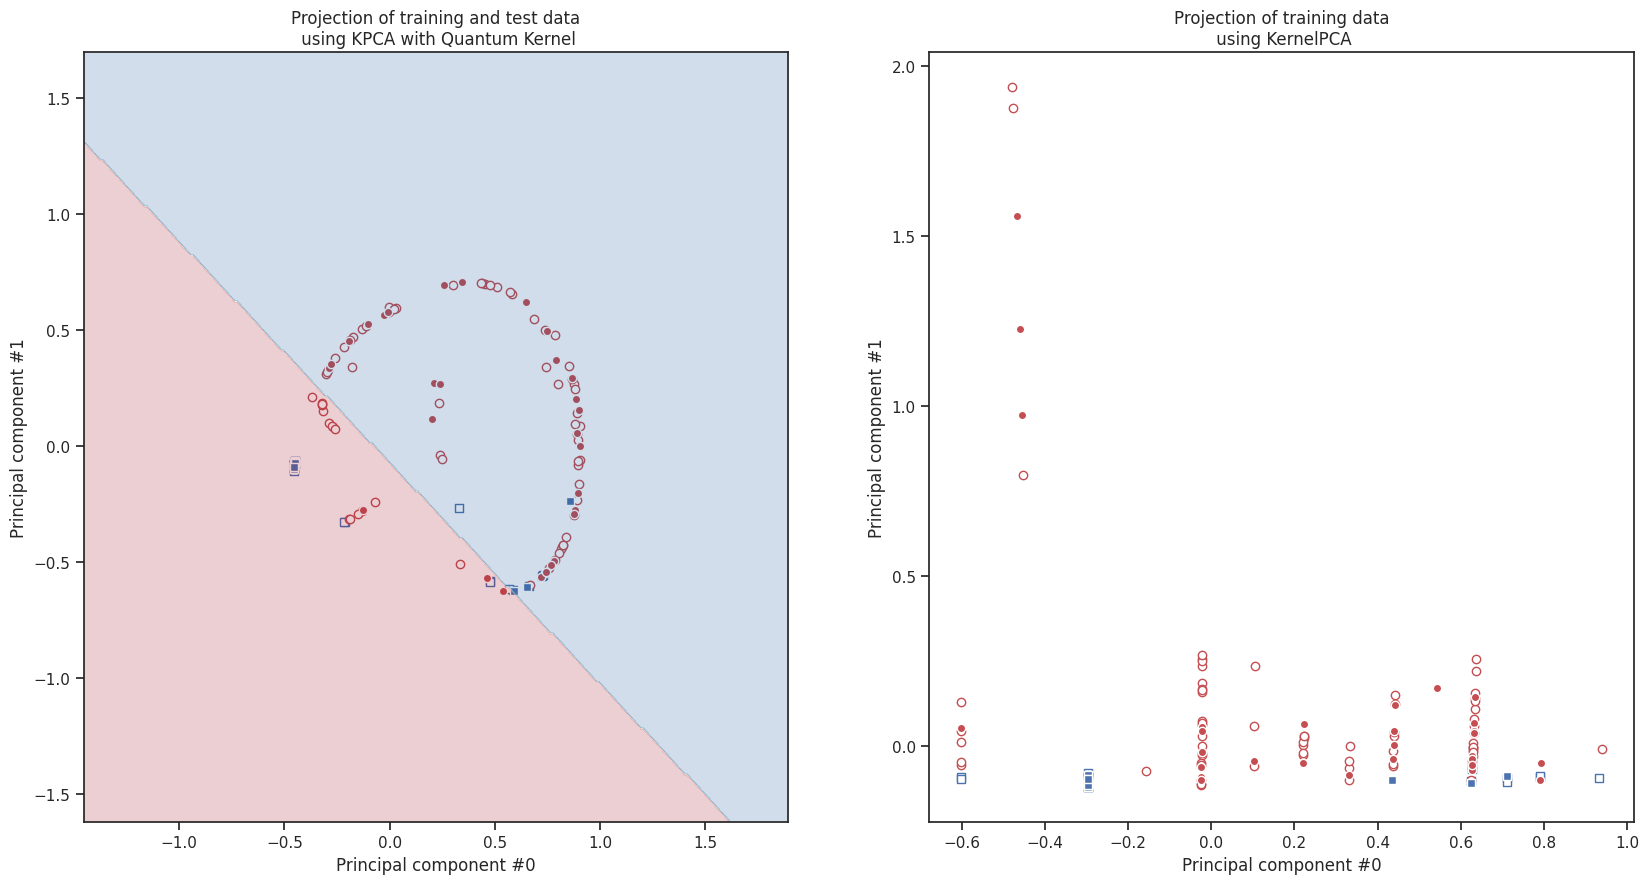

In [ ]:
# visualize the transformed features with both the quantum and classical kernel,
# and see how they linearly separate

fig, (quantum_ax, rbf_ax) = plt.subplots(1, 2, figsize=(20, 10))

plot_features(quantum_ax, X_train_quantum, y_train, 0, "s", "w", "b", "A train")
plot_features(quantum_ax, X_train_quantum, y_train, 1, "o", "w", "r", "B train")

plot_features(quantum_ax, X_test_quantum,  y_test,  0, "s", "b", "w", "A test")
plot_features(quantum_ax, X_test_quantum,  y_test,  1, "o", "r", "w", "B test")

quantum_ax.set_ylabel("Principal component #1")
quantum_ax.set_xlabel("Principal component #0")
quantum_ax.set_title("Projection of training and test data\n using KPCA with Quantum Kernel")

# Plotting the linear separation
h = 0.01  # step size in the mesh

# create a mesh to plot in
x_min, x_max = X_train_quantum[:, 0].min() - 1, X_train_quantum[:, 0].max() + 1
y_min, y_max = X_train_quantum[:, 1].min() - 1, X_train_quantum[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

predictions = logistic_regression.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
predictions = predictions.reshape(xx.shape)
quantum_ax.contourf(xx, yy, predictions, cmap = plt.cm.RdBu, alpha = 0.2)

plot_features(rbf_ax, X_train_rbf, y_train, 0, "s", "w", "b", "A train")
plot_features(rbf_ax, X_train_rbf, y_train, 1, "o", "w", "r", "B train")
plot_features(rbf_ax, X_test_rbf , y_test , 0, "s", "b", "w", "A test")
plot_features(rbf_ax, X_test_rbf , y_test , 1, "o", "r", "w", "A test")

rbf_ax.set_ylabel("Principal component #1")
rbf_ax.set_xlabel("Principal component #0")
rbf_ax.set_title("Projection of training data\n using KernelPCA")
plt.show()

## Comparison with pure classical SVC (with classical kernel)

In [143]:
# choose a sampling strategy for the large dataset, to use with the pure classical algorithms
sampling_strategy = {0: 7200, 1: 7200}

# Undersample the majority class, using a random undersampling algorithm
# We can also fix a seed for the random undersampling, in order to have reproducibility of results
undersample = RandomUnderSampler(sampling_strategy = sampling_strategy, random_state = 42)
X_resampled_large, y_resampled_large = undersample.fit_resample(X, y)

# Check class distribution after undersampling
print("Class distribution after undersampling:")
print(pd.Series(y_resampled_large).value_counts())

# Transform all the features in the interval [0, 1]
X_resampled_large = MinMaxScaler().fit_transform(X_resampled_large)

# create the large train and test datasets
X_train_large, X_test_large, y_train_large, y_test_large = train_test_split(X_resampled_large, y_resampled_large, test_size = 0.3, random_state = 0)
print(X_train_large.shape, X_test_large.shape)

Class distribution after undersampling:
fraud
0    7200
1    7200
Name: count, dtype: int64
(10080, 4) (4320, 4)


In [145]:
classic_svc = svm.SVC(kernel = "poly")
classic_svc.fit(X_train_large, y_train_large)
evaluate_with_feature_map(classic_svc, X_train_large, y_train_large, X_test_large, y_test_large, "classic poly")

classic_svc = svm.SVC(kernel = "rbf")
classic_svc.fit(X_train_large, y_train_large)
evaluate_with_feature_map(classic_svc, X_train_large, y_train_large, X_test_large, y_test_large, "classic rbf")

Classification Report for classic poly Feature Map (Train Set):

              precision    recall  f1-score   support

           0       0.91      0.92      0.92      5074
           1       0.92      0.91      0.91      5006

    accuracy                           0.92     10080
   macro avg       0.92      0.92      0.92     10080
weighted avg       0.92      0.92      0.92     10080

Confusion Matrix for Train Set:
[[4691  383]
 [ 463 4543]]


Classification Report for classic poly Feature Map (Test Set):

              precision    recall  f1-score   support

           0       0.90      0.93      0.91      2126
           1       0.93      0.90      0.91      2194

    accuracy                           0.91      4320
   macro avg       0.91      0.91      0.91      4320
weighted avg       0.91      0.91      0.91      4320

Confusion Matrix for Test Set:
[[1975  151]
 [ 219 1975]]
ROC AUC Score for classic poly Feature Map (Test Set):
0.9577
Classification Report for classic rb